We use:
- seaborn's lineplot for plotting training curves with confidence interval https://seaborn.pydata.org/generated/seaborn.lineplot.html

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import re
from tqdm import tqdm, trange

#sns.set_theme()

def load_data_files(path, name=None):
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            if data is None:
                data = run
            else:
                data = data.append(run, ignore_index=True)
    if name is not None:
        data["Name"] = name
    return data

def set_fixed_steps(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in tqdm((range(n_runs))):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print("hin?")
                continue
                
            shuffled_ids = random.sample(ids, len(ids))
            keep_id = shuffled_ids[0]
            drop_ids += shuffled_ids[1:]
            
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in trange(n_runs):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range + 1000)].index)
            
            if len(ids) == 0:
                #print(rows, s_i, "hin?")
                continue
            
            keep_id = ids[0]
            drop_ids += ids[1:]
            # For all numerical columns but the 'Step'
            for c in data.select_dtypes(include=np.number).columns:
                if c == "Step":
                    continue
                data.at[keep_id, c] = data.loc[ids][c].mean()
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg_index(data, n_index=10, diplay_prog=True):
    drop_ids = []
    range_fn = trange if diplay_prog else range
    for i in range_fn(0, len(data), n_index):
        ids = list(range(i, min(i + n_index, len(data))))
        keep_id = ids[-1]
        drop_ids += ids[:-1]
        # For all numerical columns but the 'Step'
        for c in data.select_dtypes(include=np.number).columns:
            if c == "Step":
                continue
            data.at[keep_id, c] = data.loc[ids][c].mean()
    return data.drop(drop_ids)
        
def box_plot_runs(runs, x="Step", y="Mean return", 
             ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
             legend=True, names=None, loc='best', size=(15, 6), 
             only_one_step=None, swarm=False, swarm_size=3, colors=None, no_xticks=False):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ylim is not None:
        ax.set(ylim=ylim, xlabel=ax_xlabel, ylabel=ax_ylabel)
    if only_one_step is not None:
        runs = runs.loc[runs["Step"] == only_one_step]
        x = "Name"
    if swarm:
        sns.swarmplot(x=x, y=y, hue="Name", data=runs, ax=ax, size=swarm_size, palette=colors)
        
        plt.setp(ax.get_xticklabels(), rotation=30)#, horizontalalignment="right")
    else:
        sns.boxplot(x=x, y=y, hue="Name", data=runs, ax=ax, palette=colors)
    if legend:
        if names is not None:
            ax.legend(names, loc=loc)
        else:
            ax.legend(loc=loc)
    else:
        ax.get_legend().remove()
        
    if no_xticks:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    return ax

def plot_runs(runs, x="Step", y="Episode return", estim="mean", err="sd", 
               ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, xlim=None,
               names=None, colors=None, loc='best', size=(15, 6), plot_swarm=False, 
               fs=10, no_legend=False):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
        
    if plot_swarm:
        fig, (ax, ax_swarm) = plt.subplots(1, 2, figsize=size, width_ratios=[3, 1], sharey=True)
        fig.tight_layout() 
    elif ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    if ax_xlabel is None:
        ax_xlabel = x
    ax.set_xlabel(ax_xlabel, fontsize=fs)
    if ax_ylabel is None:
        ax_ylabel = y
    ax.set_ylabel(ax_ylabel, fontsize=fs)
    
    if xlim is not None:
        ax.set(xlim=xlim)
    if ylim is not None:
        ax.set(ylim=ylim)

    sns.lineplot(data=runs, x=x, y=y, hue="Name", 
                 ax=ax, estimator=estim, errorbar=err, 
                 palette=colors, legend="brief")
    #if names is not None:
    #    ax.legend(names, loc=loc, frameon=False)
    #else:
    if not no_legend:
        ax.legend(loc=loc, fontsize=fs)
    else:
        ax.get_legend().remove()
    
    if plot_swarm:
        ax = box_plot_runs(
            runs, y=y, ax=ax_swarm, ax_ylabel=" ", ax_xlabel="Last training step",
            only_one_step=10000000, legend=False, swarm=True, swarm_size=5, no_xticks=True)
        
def load_plot_runs(path, y="Episode extrinsic return", n_index_avg=100, separate_graphs=True, ax=None,
                   ax_xlabel=None, ax_ylabel=None):
    if os.path.isfile(path):
        data = pd.read_csv(path)#, index_col=0)
        # TODO Plot single run
        
    else:
        if not separate_graphs and ax is None:
            fig, ax = plt.subplots(figsize=(15, 6))
        if ax_xlabel is not None:
            ax.set(xlabel=ax_xlabel)
        if ax_ylabel is not None:
            ax.set(ylabel=ax_ylabel)
        final_return = {}
        for file in os.listdir(path):
            print(file)
            run = pd.read_csv(os.path.join(path, file))#, index_col=0)
            #run = mov_avg(run, step_range=step_range, n_runs=1)
            run = mov_avg_index(run, n_index=n_index_avg)
            if separate_graphs:
                fig, ax = plt.subplots(figsize=(15, 6))
                ax.plot(run["Step"], run[y])
                plt.show()
            else:
                ax.plot(run["Step"], run[y])
                
            final_return[file] = run.iloc[-1][y]
            
        final_return = {k: v for k, v in sorted(final_return.items(), key=lambda item: item[1])}
        print(final_return)
        plt.show()
        
def load_mov_avg(dir_path, name, avg_range=100000, max_steps=10000000, max_n_runs=None):
    runs = []
    print("Model", dir_path, end="... ")
    for file in os.listdir(dir_path):
        print(file, end='... ')
        # Load file
        run = pd.read_csv(os.path.join(dir_path, file), index_col=0)
        # Move average
        avg_runs = []
        for s_i in range(0, max_steps, avg_range):
            range_rows = run[(run["Step"] > s_i) & (run["Step"] <= s_i + avg_range)]
            
            row = {}
            for c in run.columns:
                if c == "Step":
                    row["Step"] = s_i + avg_range
                else:
                    row[c] = range_rows[c].mean()

            avg_runs.append(row)
        runs.append(pd.DataFrame(avg_runs))
        if max_n_runs is not None and len(runs) == max_n_runs:
            break
    print("done.")
    all_runs = pd.concat(runs)
    all_runs["Name"] = name
    return all_runs

sns.set_theme(style="whitegrid")

# Differentiable architecture results

run2.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 169.45it/s]


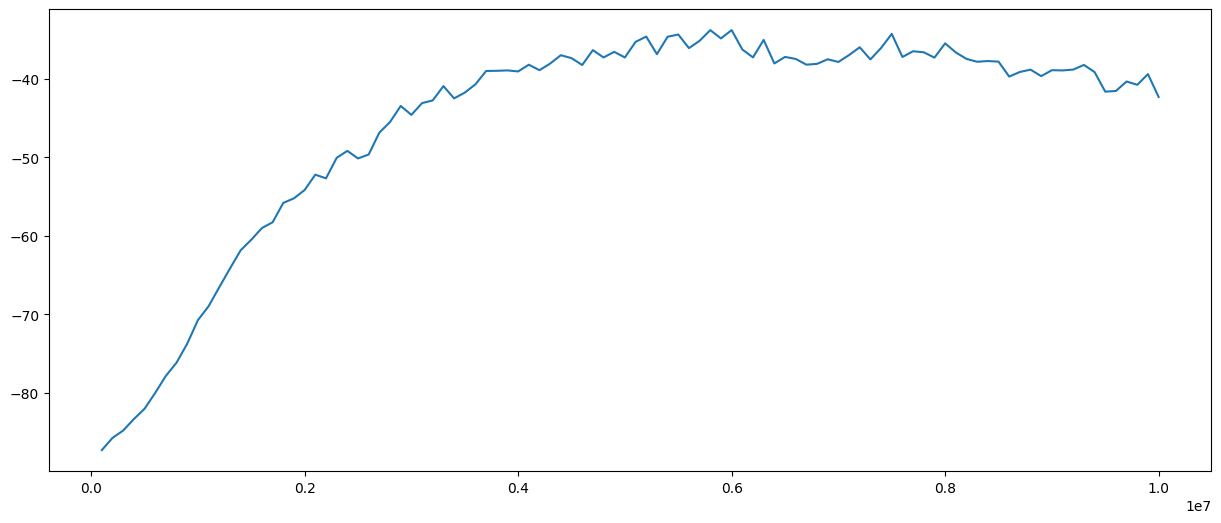

run4.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 301.48it/s]


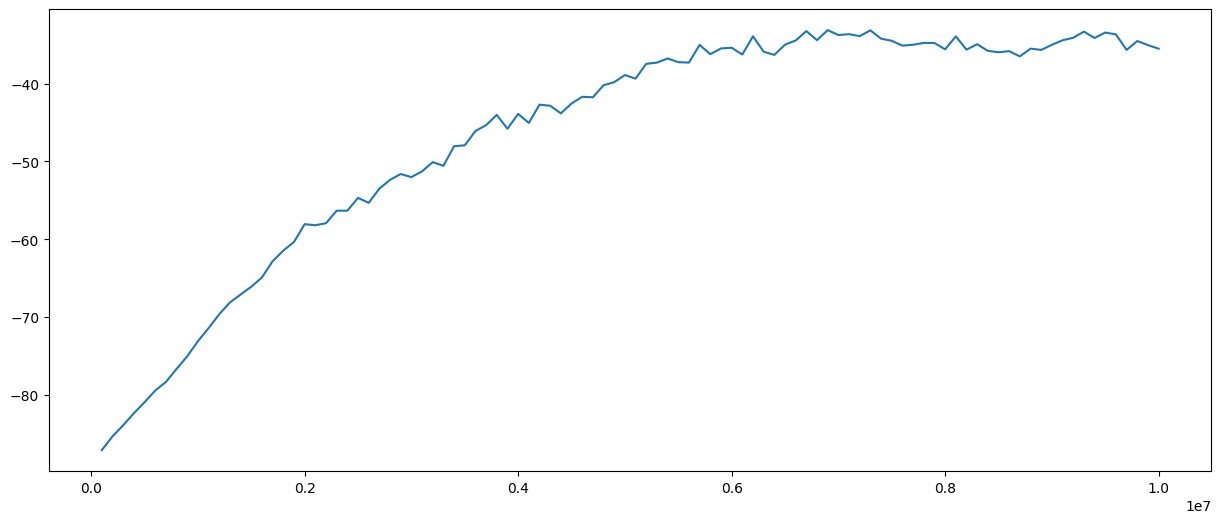

run3.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 322.74it/s]


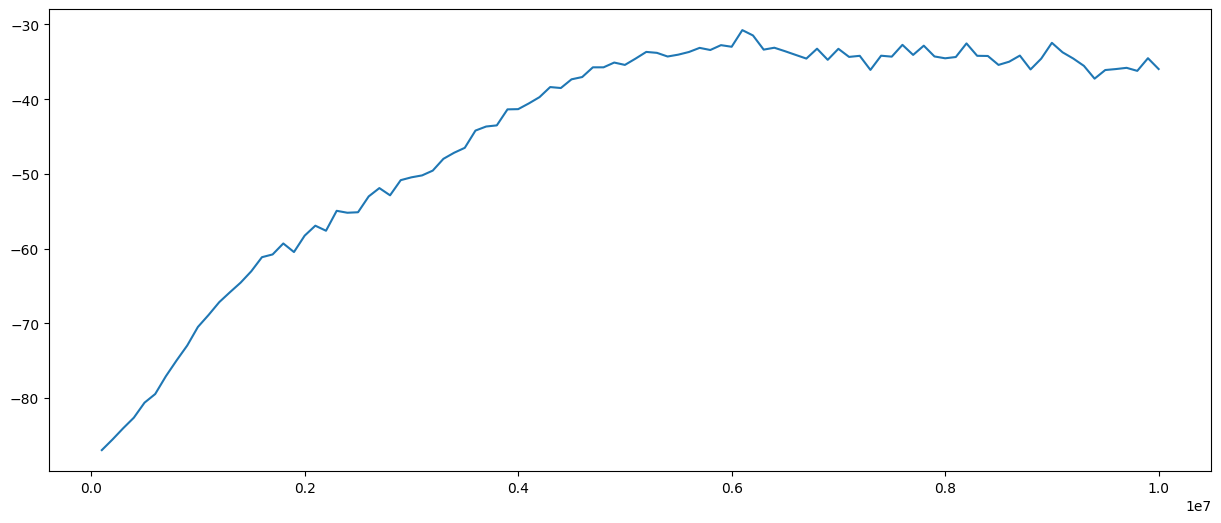

run1.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 327.06it/s]


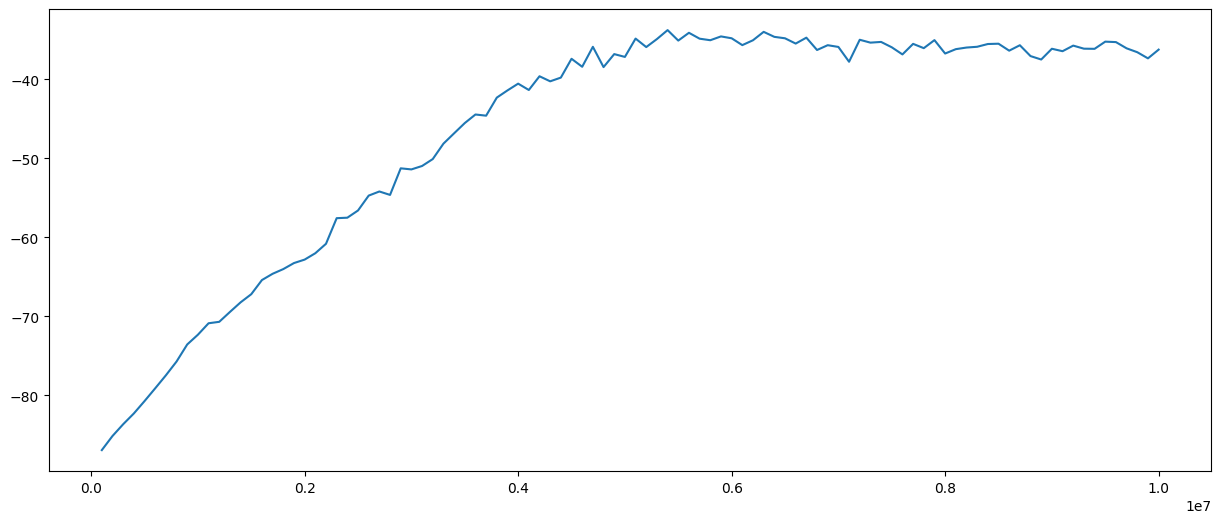

run7.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 344.44it/s]


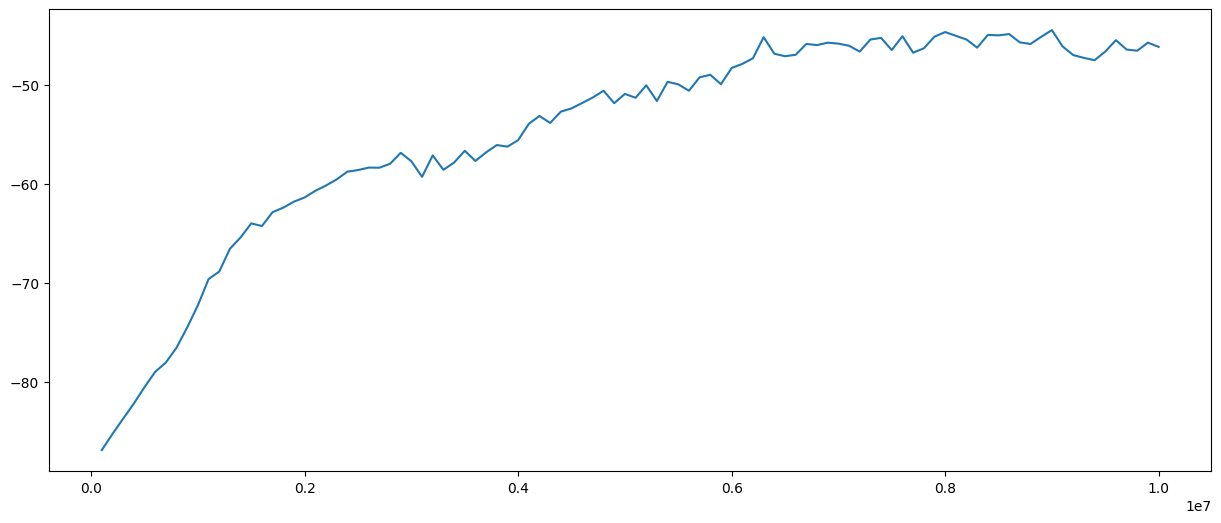

run9.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 319.50it/s]


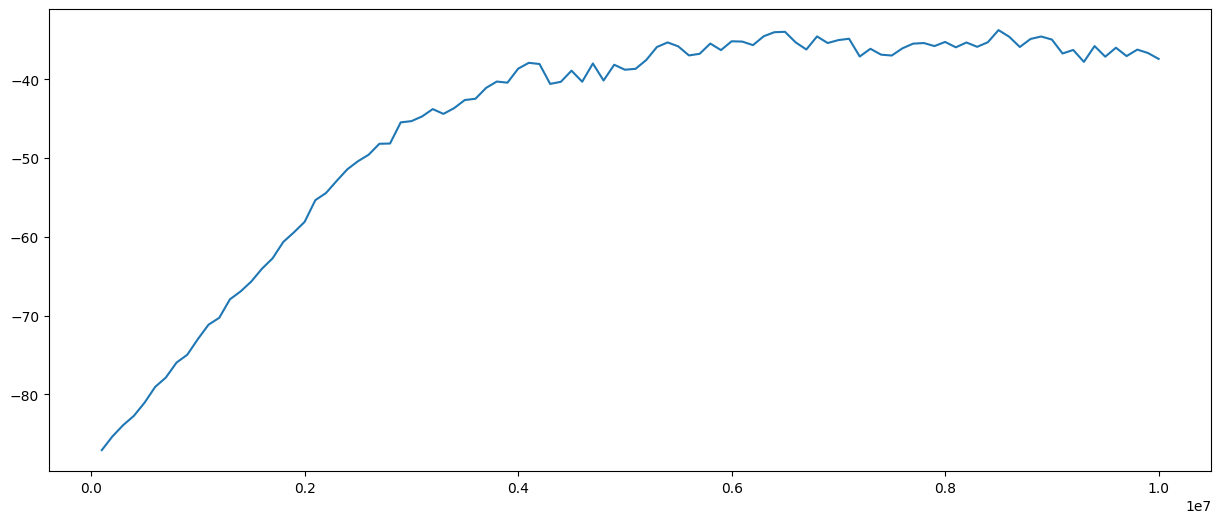

run11.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 291.90it/s]


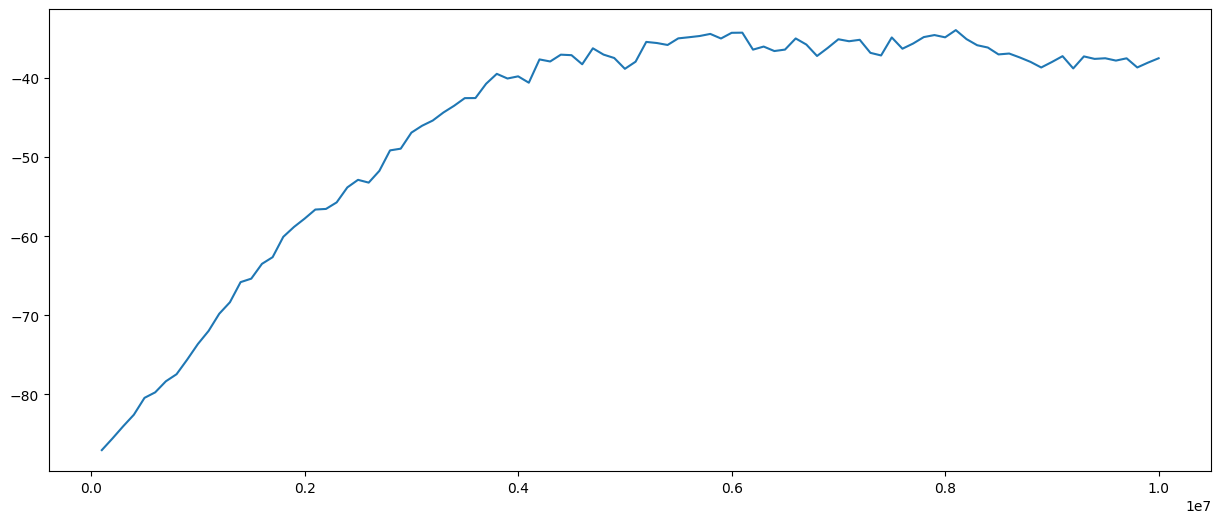

run8.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 349.86it/s]


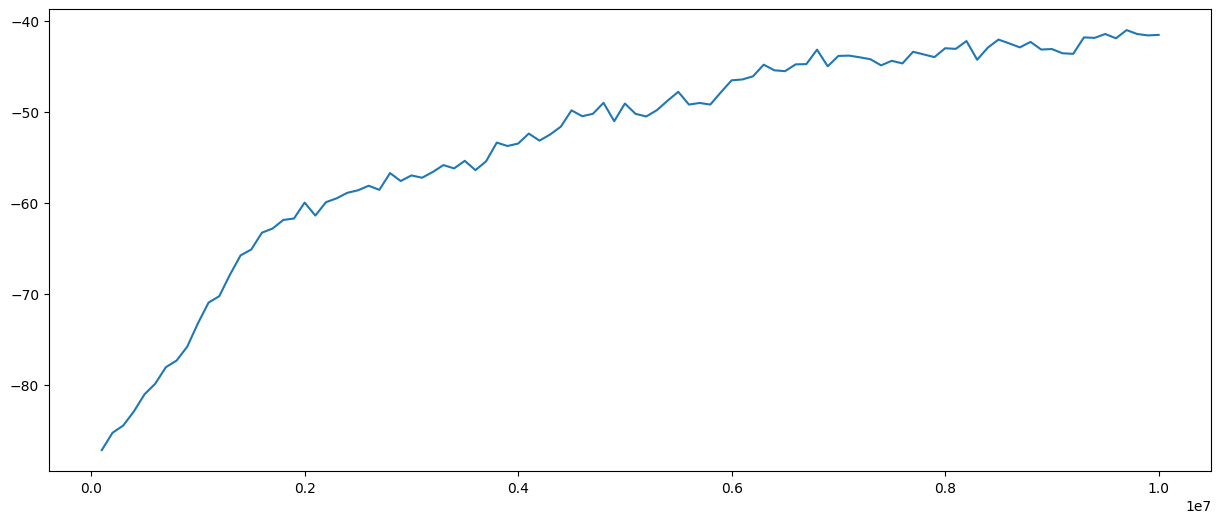

run6.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 335.59it/s]


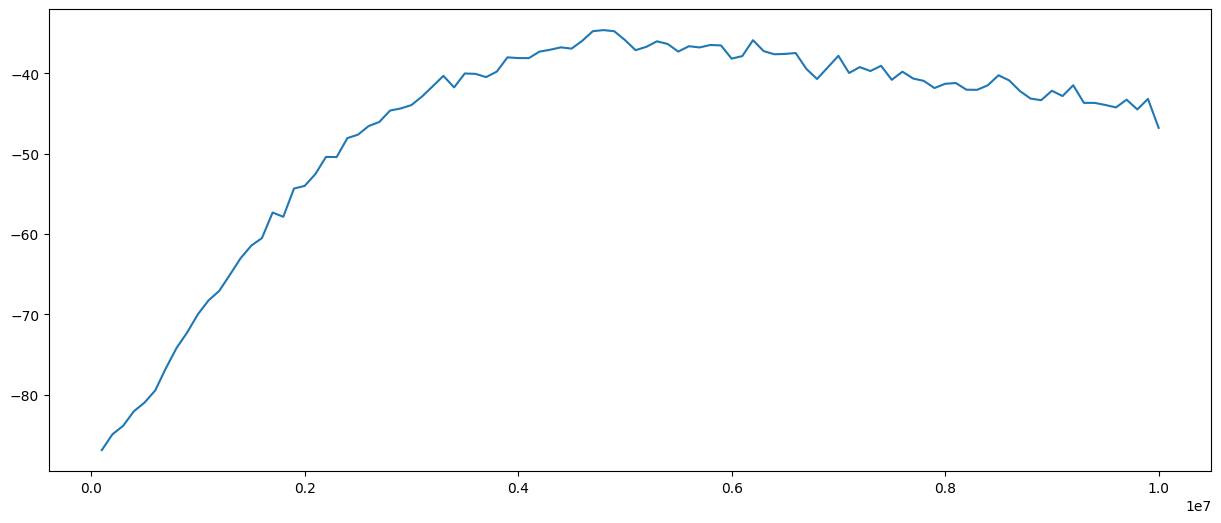

run10.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 338.42it/s]


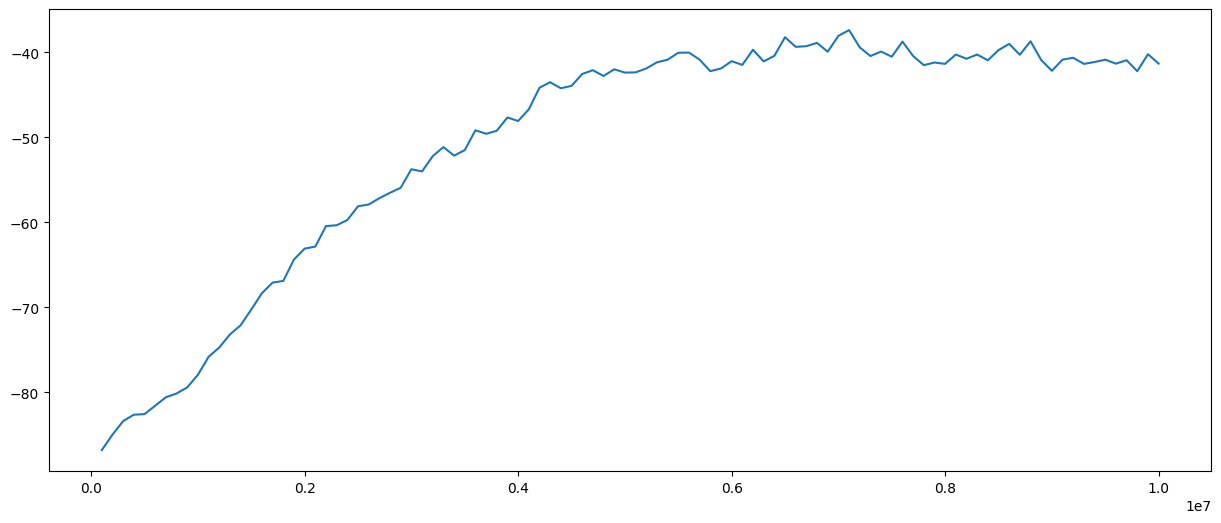

run13.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 341.92it/s]


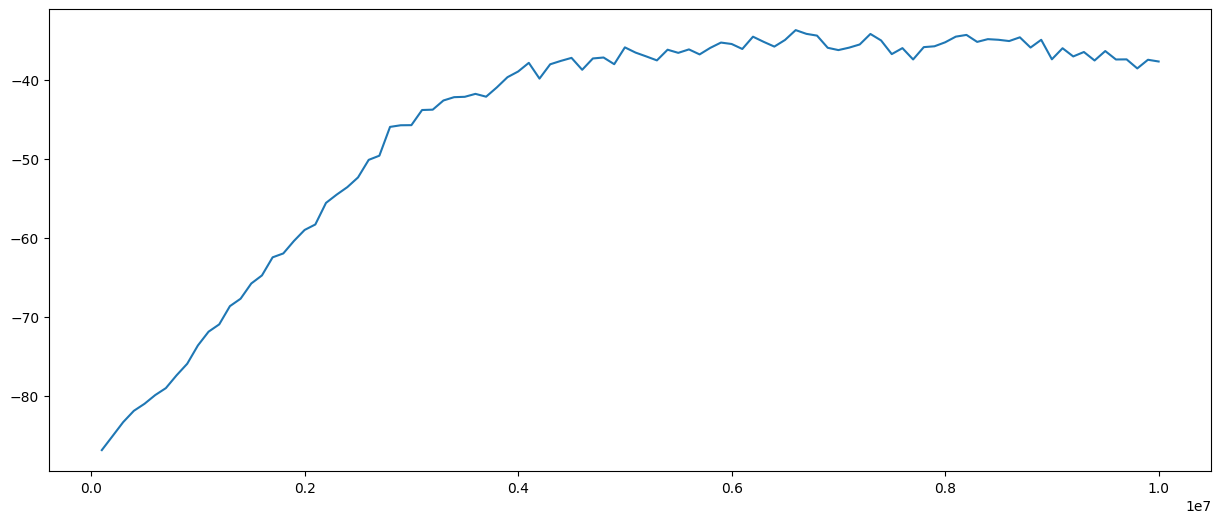

run12.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 345.93it/s]


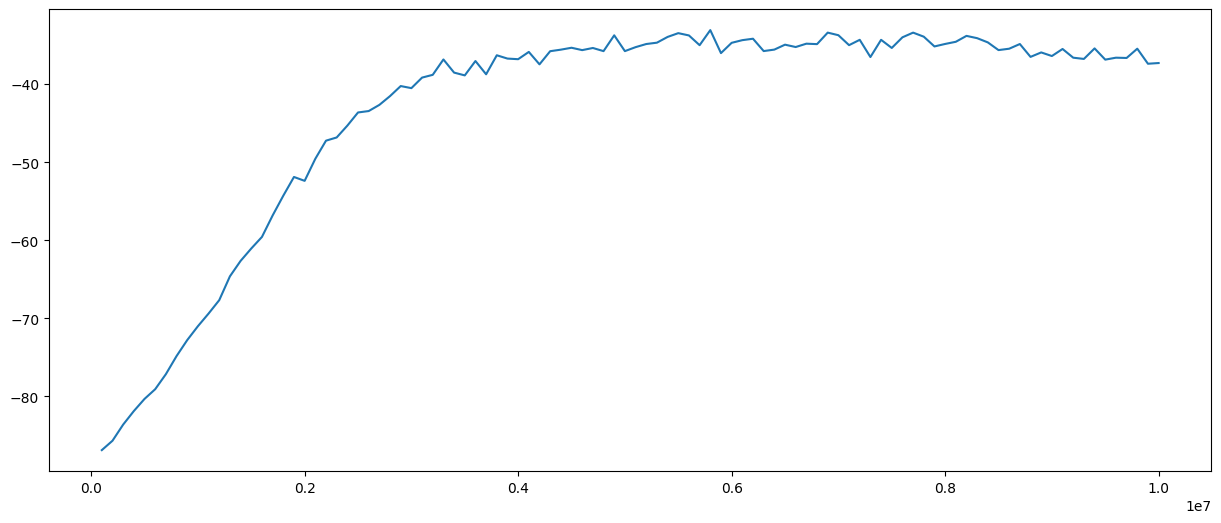

run14.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 339.07it/s]


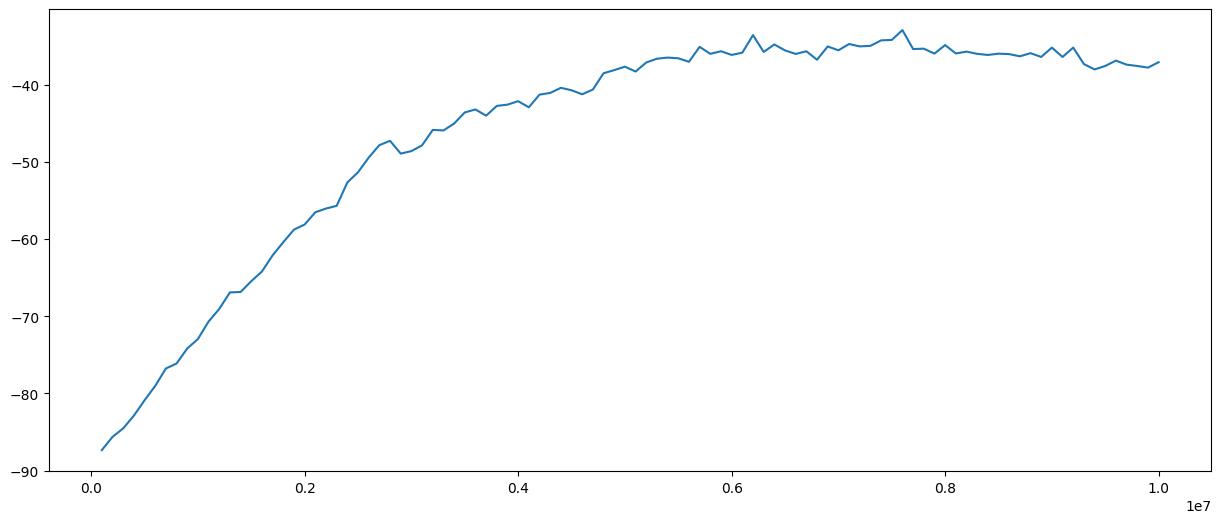

run15.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 300.25it/s]


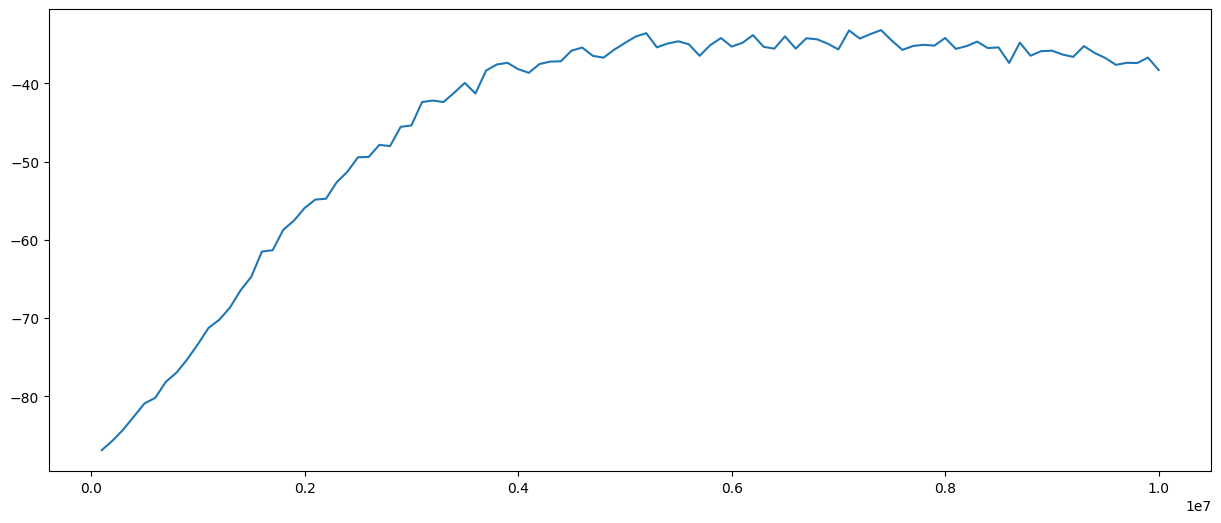

run5.csv


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 343.72it/s]


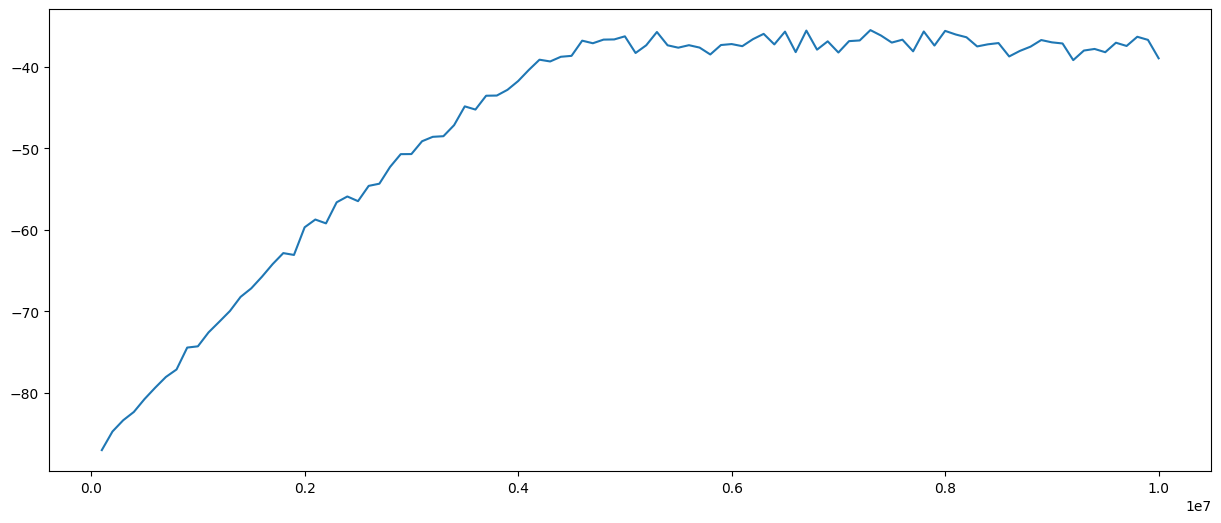

{'run6.csv': -46.799, 'run7.csv': -46.142, 'run2.csv': -42.299, 'run8.csv': -41.521, 'run10.csv': -41.314, 'run5.csv': -38.919, 'run15.csv': -38.281, 'run13.csv': -37.661, 'run11.csv': -37.504, 'run9.csv': -37.42, 'run12.csv': -37.302, 'run14.csv': -37.105, 'run1.csv': -36.215, 'run3.csv': -35.966, 'run4.csv': -35.508}


In [3]:
load_plot_runs("../models/magym_Foraging/18o5_edl/train_data/", "Episode return", n_index_avg=1000)

## See agents

In [3]:
sns.set_theme(style="whitegrid")

9x9

run17.csv - run7.csv - run9.csv - run11.csv - run18.csv - run19.csv - run8.csv - run6.csv - run20.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run21.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run17.csv - run28.csv - run23.csv - run18.csv - run19.csv - run16.csv - run25.csv - run29.csv - run20.csv - run26.csv - run27.csv - run22.csv - run15.csv - run24.csv - run21.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run17.csv - run28.csv - run23.csv - run18.csv - run19.csv - run16.csv - run25.csv - run29.csv - run20.csv - run30.csv - run26.csv - run27.csv - run22.csv - run24.csv - run21.csv - 

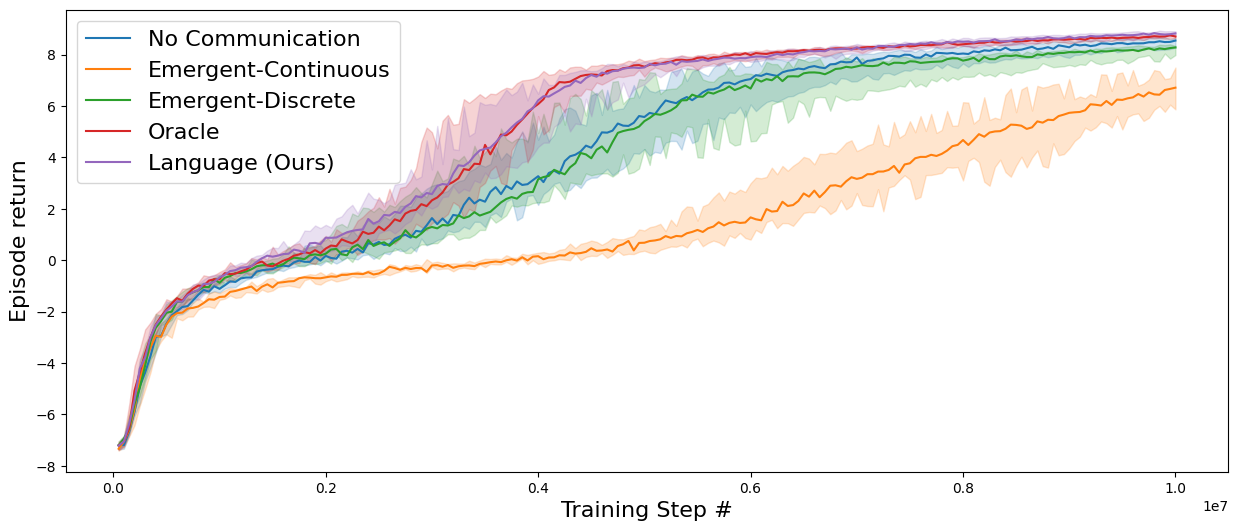

In [4]:
perf = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_perf/train_data/", 
    "Oracle", 
    50000)
lang = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_langsup/train_data/", 
    "Language (Ours)", 
    50000)
ec = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_ec2/train_data/", 
    "Emergent-Continuous", 
    50000)
ed = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_edl/train_data/", 
    "Emergent-Discrete", 
    50000)
noc = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_noc/train_data/", 
    "No Communication", 
    50000)

plot_runs([noc, ec, ed, perf, lang], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #")
plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/trainSA9.svg", bbox_inches="tight")

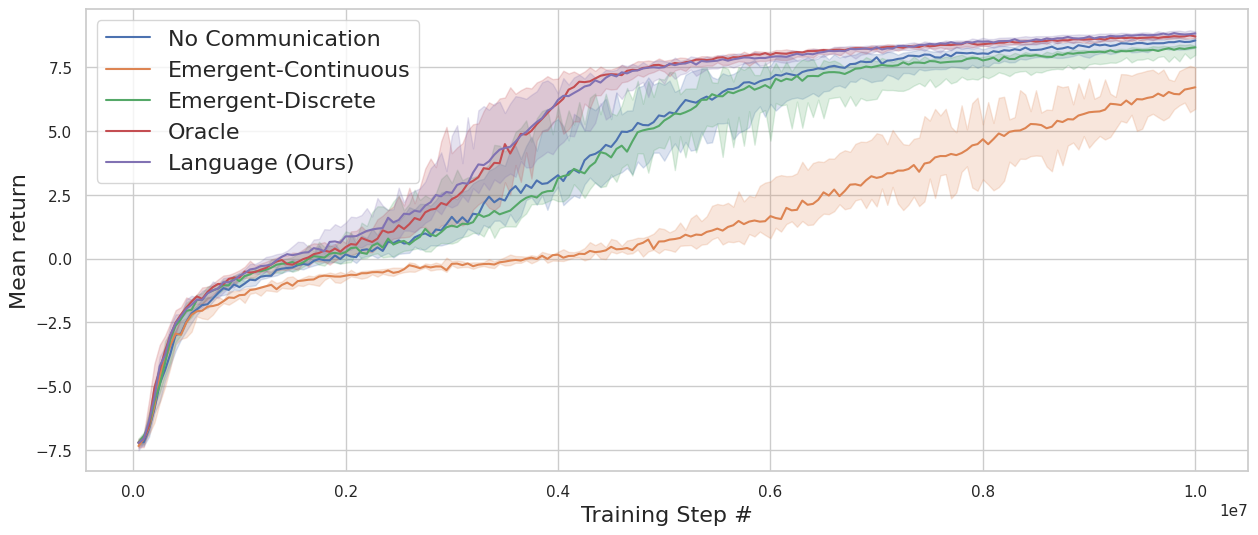

In [213]:
plot_runs([noc, ec, ed, perf, lang], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")
plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/trainSA9.svg", bbox_inches="tight")

run17.csv - run7.csv - run9.csv - run11.csv - run18.csv - run19.csv - run8.csv - run6.csv - run20.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run21.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run9.csv - run11.csv - run16.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - 

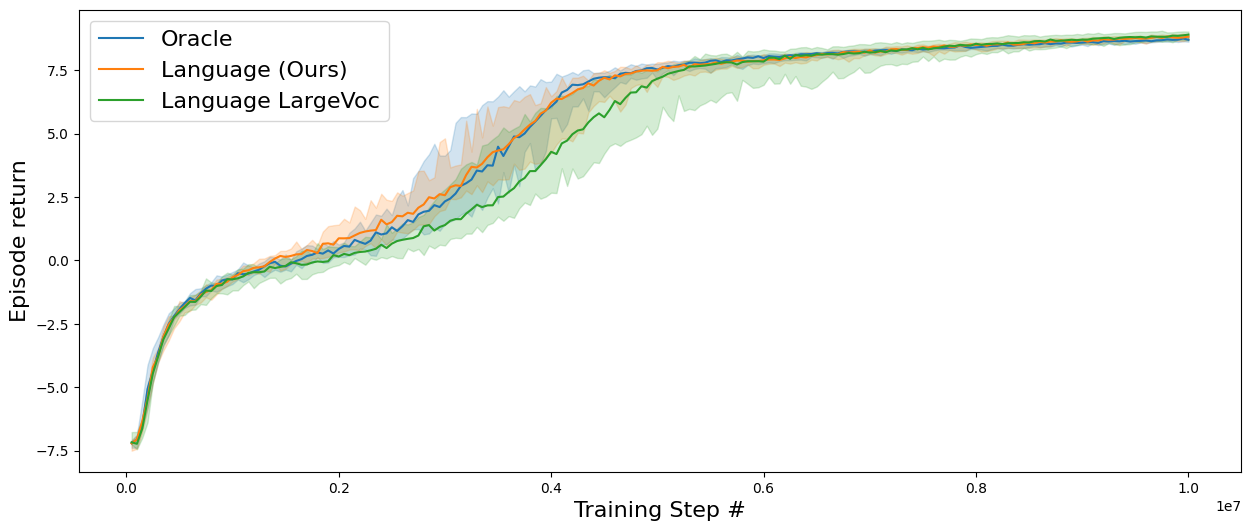

In [19]:
perf = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_perf/train_data/", 
    "Oracle", 
    50000)
lang = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_Diff_langsup/train_data/", 
    "Language (Ours)", 
    50000)
lang_largvoc = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_lang_largVoc/train_data/p2", 
    "Language LargeVoc", 
    50000)

plot_runs([perf, lang, lang_largvoc], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #")

15x15

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

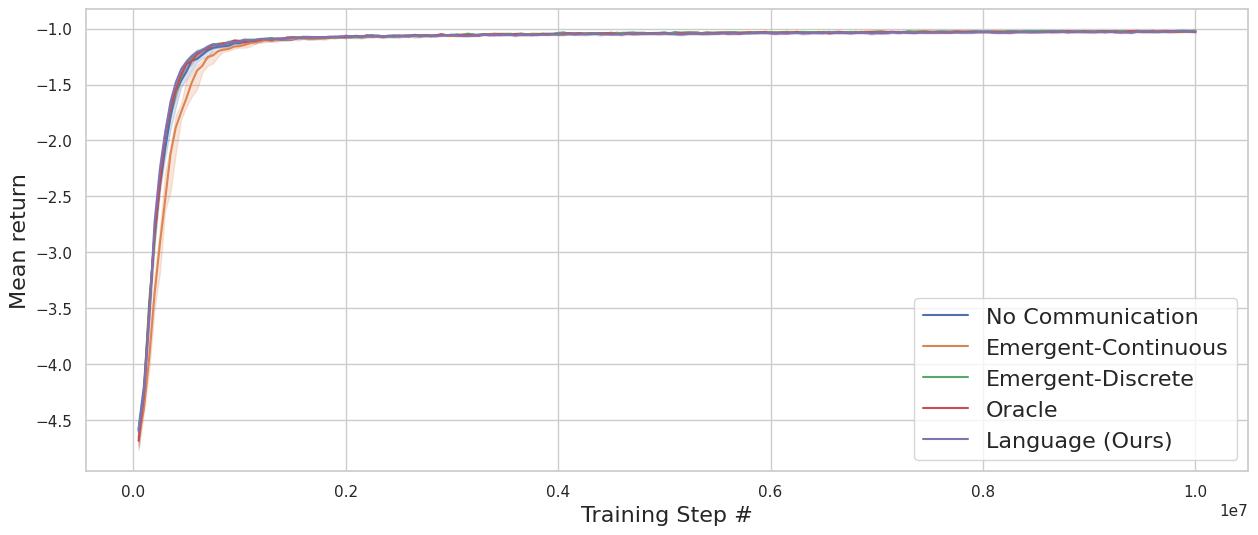

In [214]:
perf15 = load_mov_avg(
    "../models/magym_PredPrey_new/15o5SA_perfect/train_data/", 
    "Oracle", 
    50000)
lang15 = load_mov_avg(
    "../models/magym_PredPrey_new/15o5SA_langsup/train_data/", 
    "Language (Ours)", 
    50000)
ec15 = load_mov_avg(
    "../models/magym_PredPrey_new/15o5SA_ec2/train_data/", 
    "Emergent-Continuous", 
    50000)
ed15 = load_mov_avg(
    "../models/magym_PredPrey_new/15o5SA_edl/train_data/", 
    "Emergent-Discrete", 
    50000)
noc15 = load_mov_avg(
    "../models/magym_PredPrey_new/15o5SA_noc/train_data/", 
    "No Communication", 
    50000)

plot_runs([noc15, ec15, ed15, perf15, lang15], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")
plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/trainSA15.svg", bbox_inches="tight")

## Ablations

In [31]:

or_nolang = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_oracle+nolang/train_data/", 
    "Oracle+No Language", 
    50000)
nocomm_lang = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_nocom+lang/train_data/", 
    "No Comm+Language", 
    50000)
obs = load_mov_avg(
    "../models/magym_PredPrey_new/9o5SA_obs/train_data/", 
    "Observations", 
    50000)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

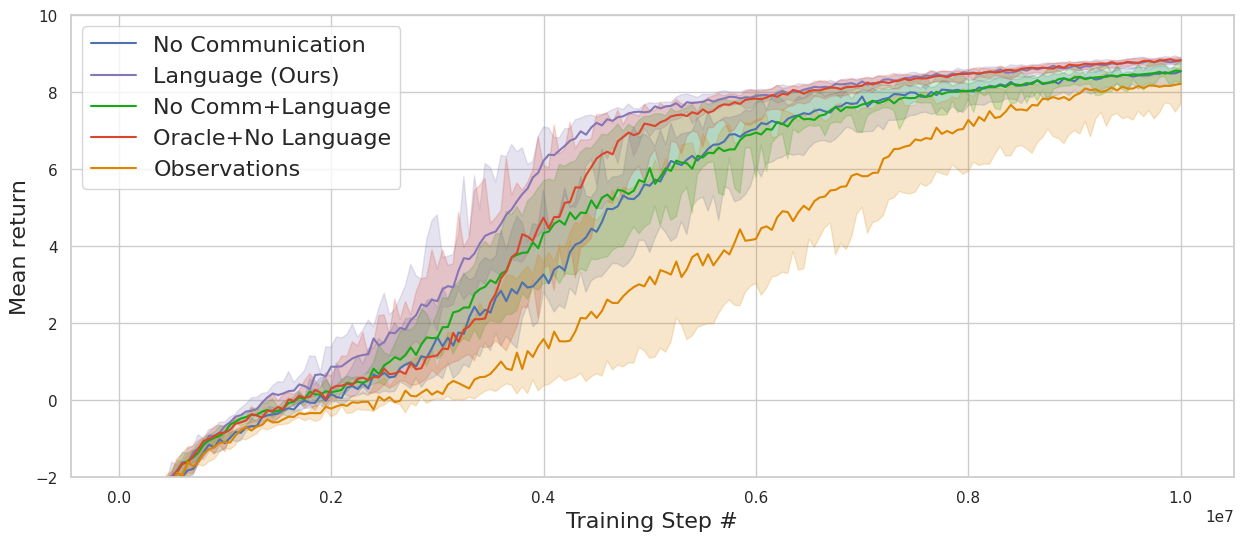

In [32]:
plot_runs([noc, lang, nocomm_lang, or_nolang, obs], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return", ylim=(-2, 10),
          colors={
              "No Communication": "#4c72b0",
              "Language (Ours)": "#8577b5",
              "Oracle+No Language": "#DB452B", 
              "No Comm+Language": "#16AB16",
              "Observations": "#DB8500"
          })
plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/ablat.svg", bbox_inches="tight")

## Adapt SA->noSA

In [41]:
perf_ad = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-noSA_Diff_perf/train_data/", 
    "perf", 
    50000)
#lang_ad = load_mov_avg(
#    "../models/magym_PredPrey_new/Adapt_9o5SA-noSA_Diff_langsup/train_data/", 
#    "lang", 
#    50000)
ec_ad = load_mov_avg(
     "../models/magym_PredPrey_new/Adapt_9o5SA-noSA_Diff_ec/train_data/", 
     "ec", 
     50000)
ed_ad = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-noSA_Diff_edl/train_data/", 
    "ed", 
    50000)
noc_ad = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-noSA_Diff_noc/train_data/", 
    "no", 
    50000)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

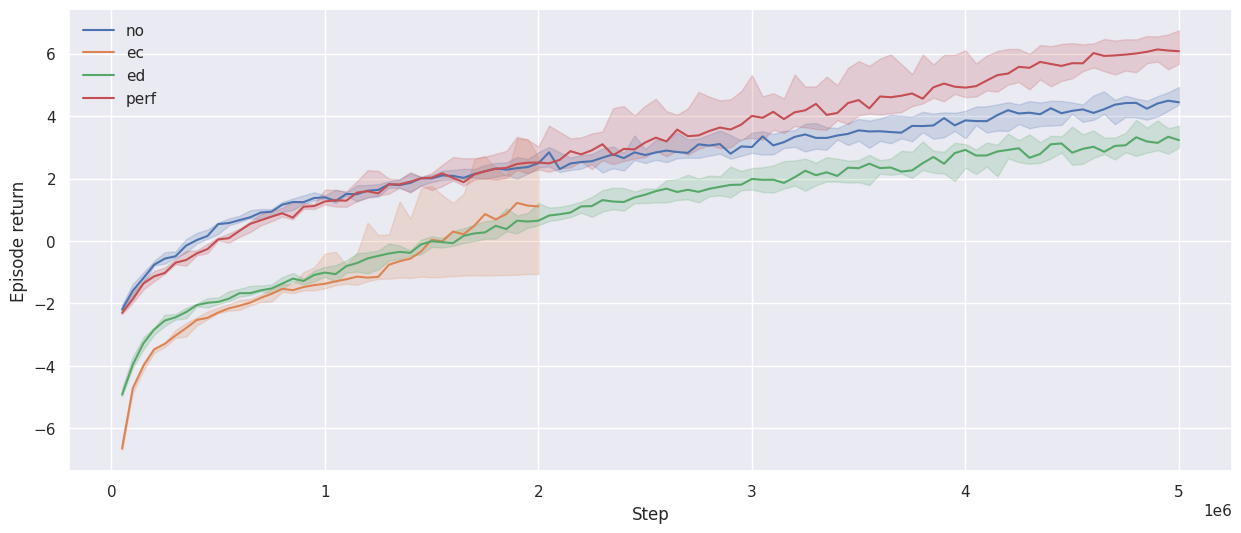

In [42]:
plot_runs([noc_ad, ec_ad, ed_ad, perf_ad], y="Episode return", estim="median", err=("ci", 95))

## Adapt 9 -> 15

In [84]:
perf_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-15o5_Diff_perf/train_data/", 
    "Perfect", 
    50000)
lang_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-15o5_Diff_langsup/train_data/", 
    "Language", 
    50000)
ec_ad15 = load_mov_avg(
     "../models/magym_PredPrey_new/Adapt_9o5SA-15o5_Diff_ec2/train_data/", 
     "Emergent-Continuous", 
     50000)
ed_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-15o5_Diff_edl/train_data/", 
    "Emergent-Discrete", 
    50000)
noc_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Adapt_9o5SA-15o5_Diff_noc/train_data/", 
    "No Comm", 
    50000)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

In [ ]:
def add_init_perf(df, perf):
    df.index += 1
    df.loc[0] = {"Step": 0, "Episode return": perf}
    df = df.sort_index()

In [226]:
perf_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_perf/train_data/", 
    "Oracle", 
    50000)
lang_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup/train_data/", 
    "Language (Ours)", 
    50000)
ec_ad15 = load_mov_avg(
     "../models/magym_PredPrey_new/Ad_9o5SA_15o5_ec2/train_data/", 
     "Emergent-Continuous", 
     50000)
ed_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_edl/train_data/", 
    "Emergent-Discrete", 
    50000)
noc_ad15 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_noc/train_data/", 
    "No Communication", 
    50000)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - 

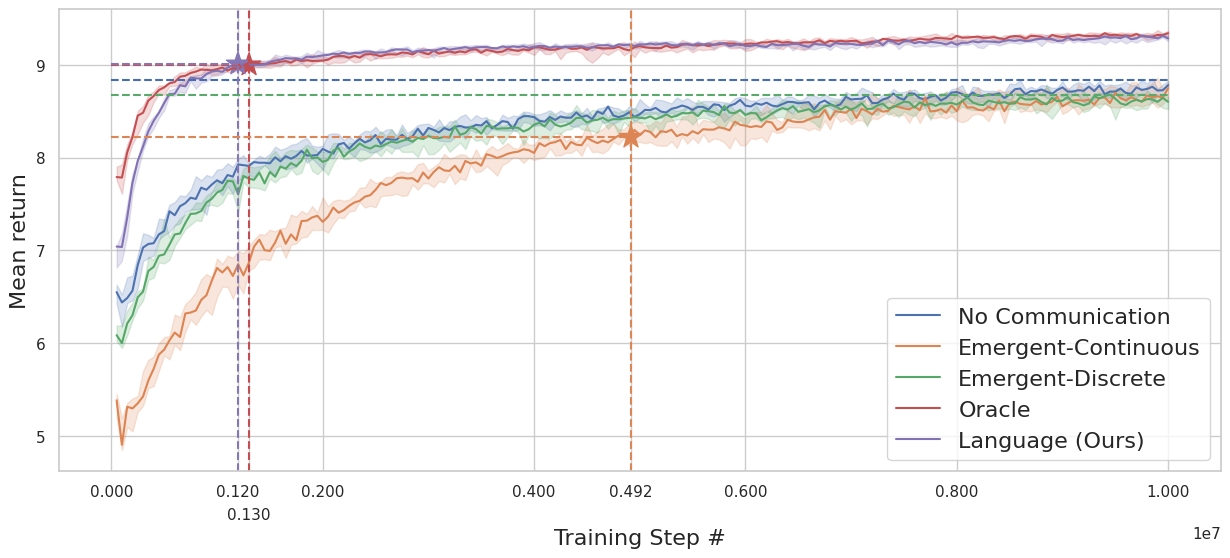

In [272]:
plot_runs([noc_ad15, ec_ad15, ed_ad15, perf_ad15, lang_ad15], 
          y="Episode return", estim="median", err=("ci", 95), 
          fs=16, ax_xlabel="Training Step #", ax_ylabel="Mean return")

# noc
plt.plot((0.0, 1e7), (8.84, 8.84), color='#466eaf', linestyle='--')
# perf
plt.plot((0.0, 1.303e6), (9.0, 9.0), color='#c34e52', linestyle='--')
plt.axvline(1.303e6, color='#c34e52', linestyle='--')
# lang
plt.plot((0.0, 1.198e6), (9.01, 9.01), color='#8577b5', linestyle='--')
plt.axvline(1.198e6, color='#8577b5', linestyle='--')
# ec2
plt.plot((0.0, 4.917e6), (8.22, 8.22), color='#dd8655', linestyle='--')
plt.axvline(4.917e6, color='#dd8655', linestyle='--')
# edl
plt.plot((0.0, 1e7), (8.68, 8.68), color='#59a96b', linestyle='--')

plt.scatter([1.303e6, 1.198e6, 4.917e6], [9.0, 9.01, 8.22], s=300, c=['#c34e52', '#8577b5', '#dd8655'], marker='*')

plt.xticks(list(plt.xticks()[0])[1:-1] + [1.198e6, 1.303e6, 4.917e6])

ax = plt.gca()
for tick in ax.get_xticklabels():
    if tick.get_position()[0] in [1.303e6]:
        tick.set_y(-0.05) 

plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/AdSA9_15.svg", bbox_inches="tight")

In [223]:
lang_ad15nofrz = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup/train_data/", 
    "Language (Ours)", 
    50000)
lang_ad15frz0 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzl0/train_data/", 
    "Language (Frozen)", 
    50000)
lang_ad15frz10k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE10k/train_data/", 
    "Language (Frozen-10k)", 
    50000)
lang_ad15frz50k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE50k/train_data/", 
    "Language (Frozen-50k)", 
    50000)
lang_ad15frz100k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE100k/train_data/", 
    "Language (Frozen-100k)", 
    50000)
lang_ad15frz500k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE500k/train_data/", 
    "Language (Frozen-500k)", 
    50000)
lang_ad15frz1M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE1M/train_data/", 
    "Language (Frozen-1M)", 
    50000)
lang_ad15frz2M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE2M/train_data/", 
    "Language (Frozen-2M)", 
    50000)
lang_ad15frz5M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE5M/train_data/", 
    "Language (Frozen-5M)", 
    50000)

ratio_genperf_ad15nofrz = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup/comm_data/", 
    "Language (Ours)", 
    50000)
ratio_genperf_ad15frz0 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzl0/comm_data/", 
    "Language (Frozen)", 
    50000)
ratio_genperf_ad15frz10k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE10k/comm_data/", 
    "Language (Frozen-10k)", 
    50000)
ratio_genperf_ad15frz50k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE50k/comm_data/", 
    "Language (Frozen-50k)", 
    50000)
ratio_genperf_ad15frz100k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE100k/comm_data/", 
    "Language (Frozen-100k)", 
    50000)
ratio_genperf_ad15frz500k = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE500k/comm_data/", 
    "Language (Frozen-500k)", 
    50000)
ratio_genperf_ad15frz1M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE1M/comm_data/", 
    "Language (Frozen-1M)", 
    50000)
ratio_genperf_ad15frz2M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE2M/comm_data/", 
    "Language (Frozen-2M)", 
    50000)
ratio_genperf_ad15frz5M = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_15o5_langsup_frzlCE5M/comm_data/", 
    "Language (Frozen-5M)", 
    50000)

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv -

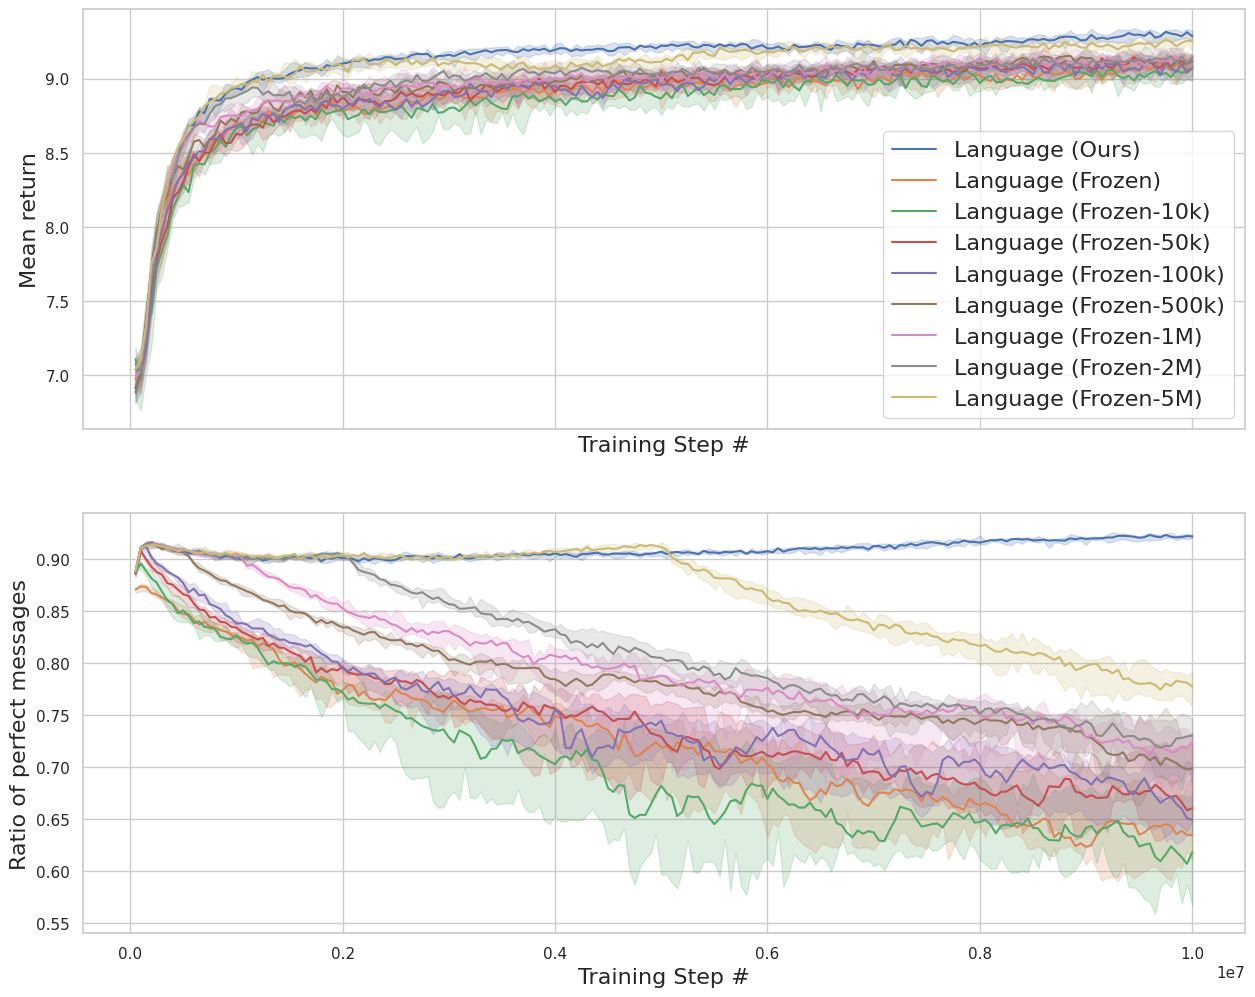

In [238]:
fig, axs = plt.subplots(2, sharex=True, figsize=(15, 12))

plot_runs(
    [lang_ad15nofrz, lang_ad15frz0, lang_ad15frz10k, lang_ad15frz50k, lang_ad15frz100k, 
     lang_ad15frz500k, lang_ad15frz1M, lang_ad15frz2M, lang_ad15frz5M], 
    y="Episode return", estim="median", err=("ci", 95), ax=axs[0], 
    fs=16, ax_xlabel="Training Step #", ax_ylabel="Mean return")
plot_runs(
    [ratio_genperf_ad15nofrz, ratio_genperf_ad15frz0, ratio_genperf_ad15frz10k, ratio_genperf_ad15frz50k, 
     ratio_genperf_ad15frz100k, ratio_genperf_ad15frz500k, ratio_genperf_ad15frz1M, ratio_genperf_ad15frz2M,
     ratio_genperf_ad15frz5M], 
    y="Ratio_gen_perf", estim="median", err=("ci", 95), ax=axs[1], ax_ylabel="Ratio of perfect messages", 
    fs=16, ax_xlabel="Training Step #", no_legend=True)

plt.savefig("/home/doctoq/Desktop/Rédac/LAMAC_figs/AdSA9_15_frzl.svg", bbox_inches="tight")

Adapt 9x9 -> 24x24

run2.csv - run4.csv - run3.csv - run1.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - 

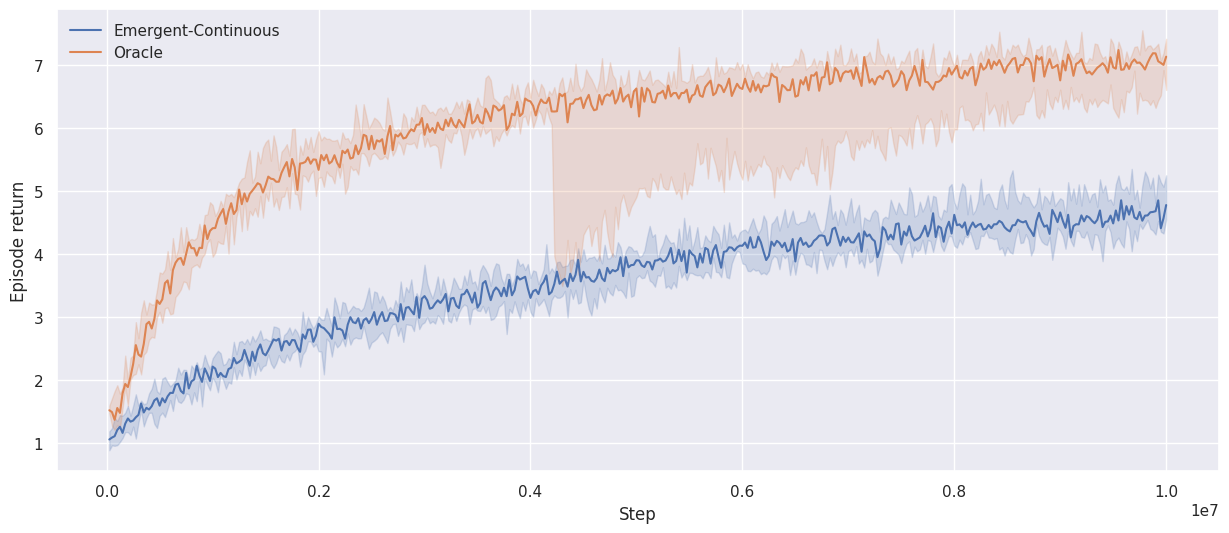

In [157]:
perf_ad24 = load_mov_avg(
    "../models/magym_PredPrey_new/Ad_9o5SA_24o5_perf/train_data/", 
    "Oracle", 
    25000)
ec_ad24 = load_mov_avg(
     "../models/magym_PredPrey_new/Ad_9o5SA_24o5_ec2/train_data/", 
     "Emergent-Continuous", 
     25000)
plot_runs([ec_ad24, perf_ad24], y="Episode return", estim="median", err=("ci", 95))

### New reward

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

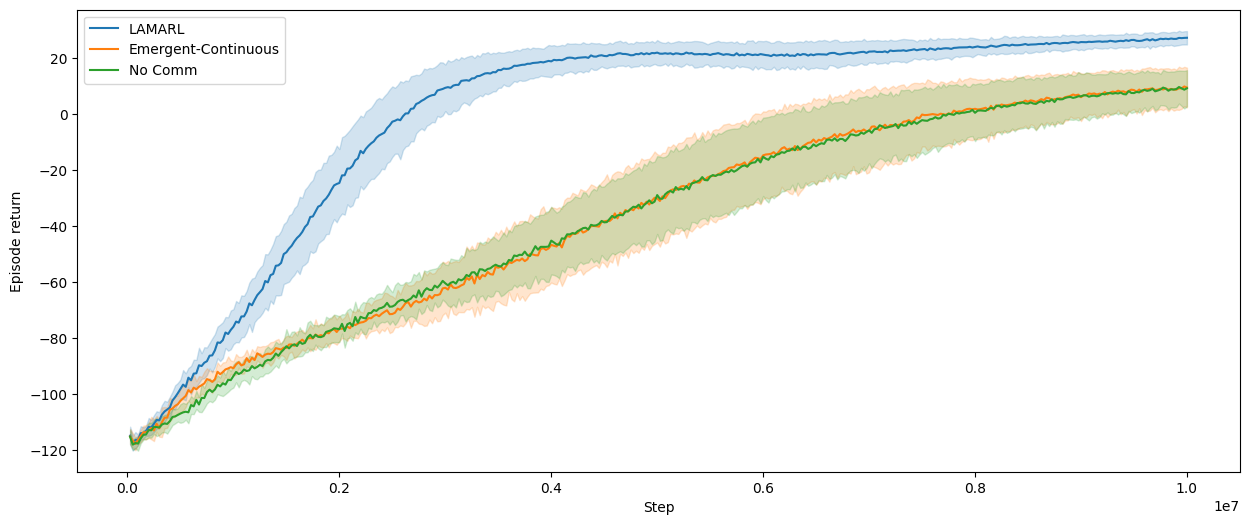

In [5]:
lang = load_mov_avg(
    "../models/magym_PredPrey_newReward/9_lang_deeper/train_data/", 
    "LAMARL", 
    25000)
ec = load_mov_avg(
     "../models/magym_PredPrey_newReward/9_ec2/train_data/", 
     "Emergent-Continuous", 
     25000)
noc = load_mov_avg(
     "../models/magym_PredPrey_newReward/9_noc_deeper/train_data/", 
     "No Comm", 
     25000)
plot_runs([lang, ec, noc], y="Episode return")

### RGB

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

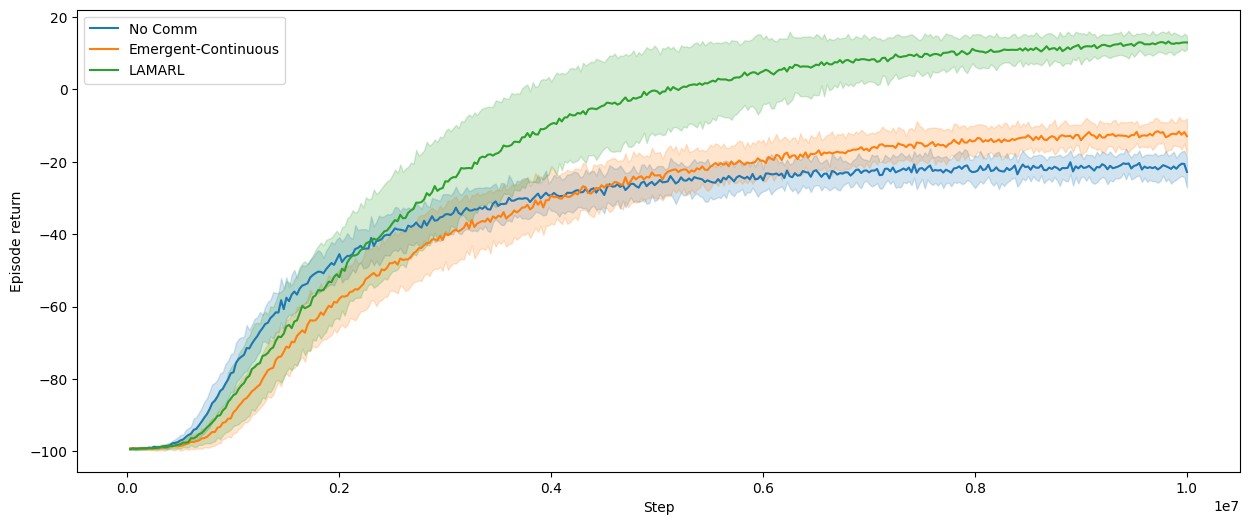

In [7]:
lang = load_mov_avg(
    "../models/magym_PredPrey_RGB/18np3a_lang/train_data/", 
    "LAMARL", 
    25000)
ec = load_mov_avg(
     "../models/magym_PredPrey_RGB/18np3a_ec2/train_data/", 
     "Emergent-Continuous", 
     25000)
noc = load_mov_avg(
     "../models/magym_PredPrey_RGB/18np3a_noc/train_data/", 
     "No Comm", 
     25000)
plot_runs([noc, ec, lang], y="Episode return")

run10.csv


100%|██████████| 392/392 [00:00<00:00, 1158.35it/s]


run11.csv


 87%|████████▋ | 340/389 [00:00<00:00, 1135.27it/s]/tmp/ipykernel_5819/2595243070.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '223104.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[keep_id, c] = data.loc[ids][c].mean()
100%|██████████| 389/389 [00:00<00:00, 1131.83it/s]


run6.csv


 88%|████████▊ | 346/391 [00:00<00:00, 1145.20it/s]/tmp/ipykernel_5819/2595243070.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '224490.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[keep_id, c] = data.loc[ids][c].mean()
100%|██████████| 391/391 [00:00<00:00, 1139.90it/s]


run15.csv


100%|██████████| 393/393 [00:00<00:00, 1160.42it/s]


run7.csv


100%|██████████| 389/389 [00:00<00:00, 1157.43it/s]


run1.csv


 90%|█████████ | 353/392 [00:00<00:00, 1139.32it/s]/tmp/ipykernel_5819/2595243070.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '224944.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[keep_id, c] = data.loc[ids][c].mean()
100%|██████████| 392/392 [00:00<00:00, 1140.22it/s]


run9.csv


100%|██████████| 390/390 [00:00<00:00, 1143.09it/s]


run3.csv


100%|██████████| 390/390 [00:00<00:00, 1134.49it/s]


run14.csv


100%|██████████| 391/391 [00:00<00:00, 1154.24it/s]


run12.csv


100%|██████████| 392/392 [00:00<00:00, 1135.14it/s]


run5.csv


100%|██████████| 390/390 [00:00<00:00, 1129.95it/s]


run2.csv


100%|██████████| 391/391 [00:00<00:00, 1101.41it/s]


run13.csv


100%|██████████| 393/393 [00:00<00:00, 1175.47it/s]


run8.csv


 92%|█████████▏| 360/391 [00:00<00:00, 1197.03it/s]/tmp/ipykernel_5819/2595243070.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '224477.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[keep_id, c] = data.loc[ids][c].mean()
100%|██████████| 391/391 [00:00<00:00, 1191.68it/s]


run4.csv


100%|██████████| 390/390 [00:00<00:00, 1193.02it/s]


{'run5.csv': -9.60392156862745, 'run1.csv': -8.2375, 'run12.csv': -7.688372093023256, 'run9.csv': -6.5961945031712474, 'run7.csv': -6.545098039215686, 'run2.csv': -5.638009049773756, 'run3.csv': -5.220264317180617, 'run14.csv': -4.484848484848484, 'run13.csv': -4.121212121212121, 'run6.csv': -3.5145228215767634, 'run8.csv': -3.4671052631578947, 'run4.csv': -3.393939393939394, 'run10.csv': -2.882758620689655, 'run15.csv': -1.624229979466119, 'run11.csv': 4.9}


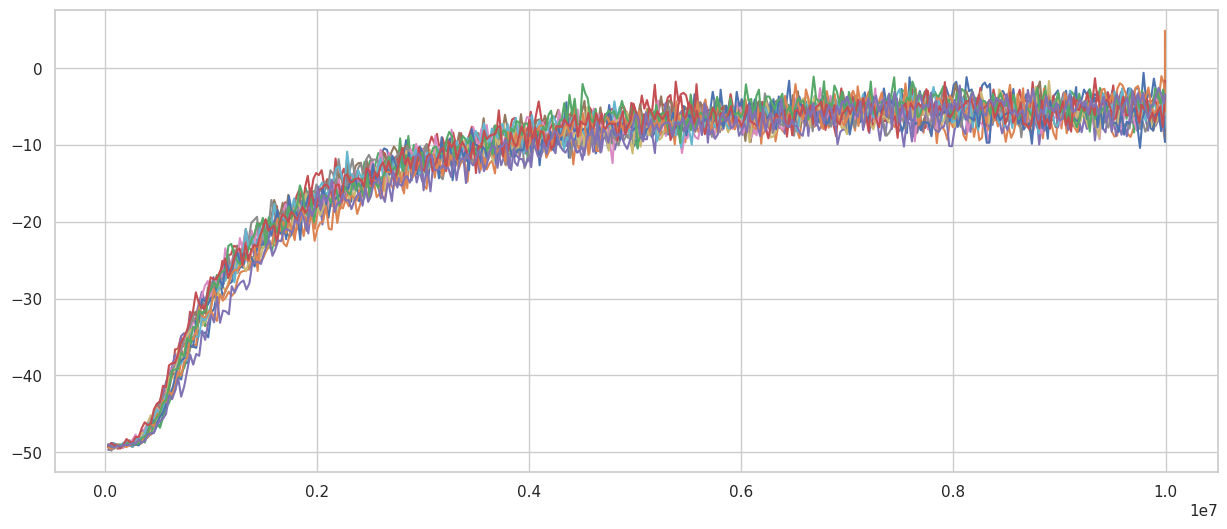

In [32]:
load_plot_runs("../models/magym_PredPrey_RGB/18s50np_noc/train_data/", "Episode return", n_index_avg=575, separate_graphs=False)

Model ../models/magym_PredPrey_RGB/18s50np_lang/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... run3.csv... run14.csv... run12.csv... run5.csv... run2.csv... run13.csv... run8.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_lang_ce0/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... run3.csv... run14.csv... run12.csv... run5.csv... run2.csv... run13.csv... run8.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_oracle/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... run3.csv... run14.csv... run12.csv... run5.csv... run2.csv... run13.csv... run8.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_ec2/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... run3.csv... run14.csv... run12.csv... run5.csv... run2.csv... run13.csv... run8.

/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

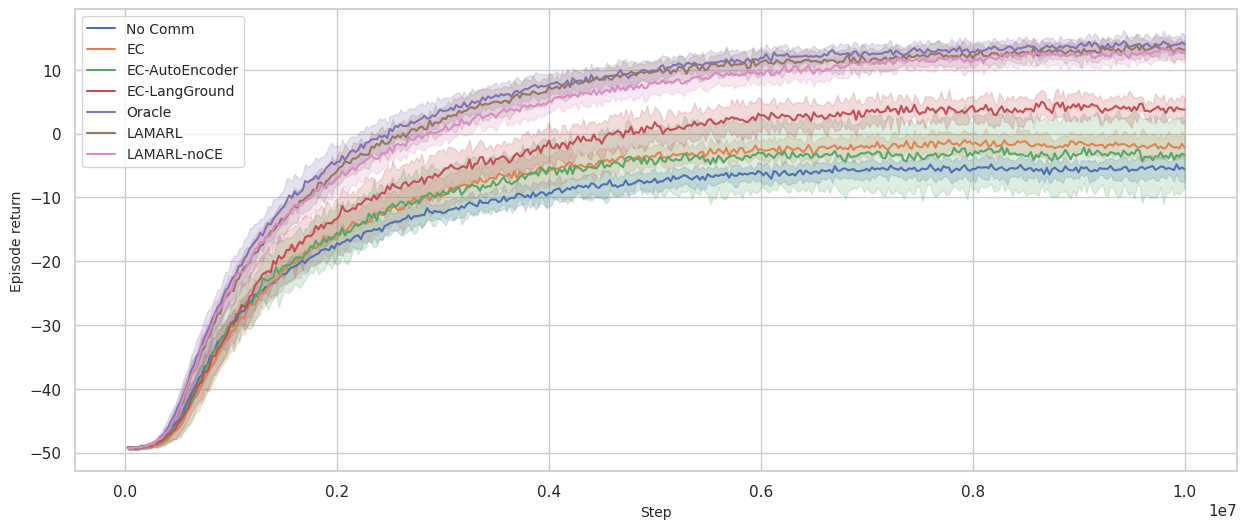

In [ ]:
lang_18 = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_lang/train_data/", 
    "LAMARL", 
    25000)
lang_ce0_18 = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_lang_ce0/train_data/", 
    "LAMARL-noCE", 
    25000)
oracle_18 = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_oracle/train_data/", 
     "Oracle", 
     25000)
ec_18 = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_ec2/train_data/", 
     "EC", 
     25000)
ec_ae_18 = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_ec2_ae/train_data/", 
     "EC-AutoEncoder", 
     25000)
ec_lg_18 = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_ec4_lg/train_data/", 
     "EC-LangGround", 
     25000)
noc_18 = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_noc/train_data/", 
     "No Comm", 
     25000)

plot_runs([noc_18, ec_18, ec_ae_18, ec_lg_18, oracle_18, lang_18, lang_ce0_18], y="Episode return")

PP_15

Model ../models/magym_PredPrey_RGB/15s50np_lang/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/15s50np_ec2_ae/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/15s50np_ec2/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/15s50np_ec4_lg/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/15s50np_noc/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.


/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

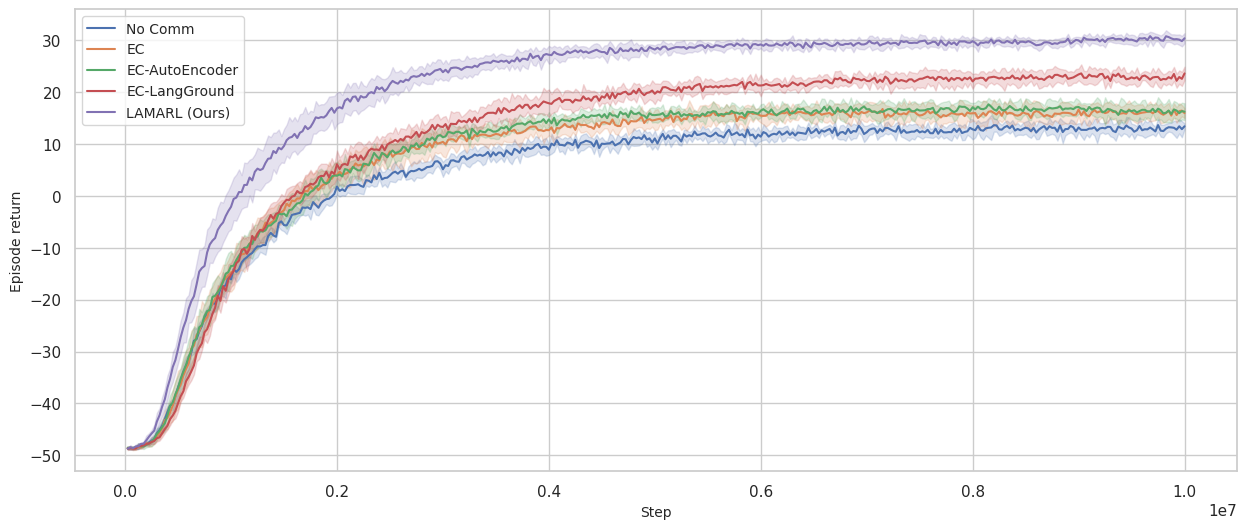

In [8]:
lang = load_mov_avg(
    "../models/magym_PredPrey_RGB/15s50np_lang/train_data/", 
    "LAMARL (Ours)", 
    25000, max_n_runs=7)
ec2_ae = load_mov_avg(
     "../models/magym_PredPrey_RGB/15s50np_ec2_ae/train_data/", 
     "EC-AutoEncoder", 
     25000, max_n_runs=7)
ec = load_mov_avg(
     "../models/magym_PredPrey_RGB/15s50np_ec2/train_data/", 
     "EC", 
     25000, max_n_runs=7)
ec4_lg = load_mov_avg(
     "../models/magym_PredPrey_RGB/15s50np_ec4_lg/train_data/", 
     "EC-LangGround", 
     25000, max_n_runs=7)
noc = load_mov_avg(
     "../models/magym_PredPrey_RGB/15s50np_noc/train_data/", 
     "No Comm", 
     25000, max_n_runs=7)

plot_runs([noc, ec, ec2_ae, ec4_lg, lang], y="Episode return")

PP_12

Model ../models/magym_PredPrey_RGB/12s50np_lang/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/12s50np_ec2_ae/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/12s50np_ec2/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run8.csv... done.
Model ../models/magym_PredPrey_RGB/12s50np_ec4_lg/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/12s50np_noc/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.


/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

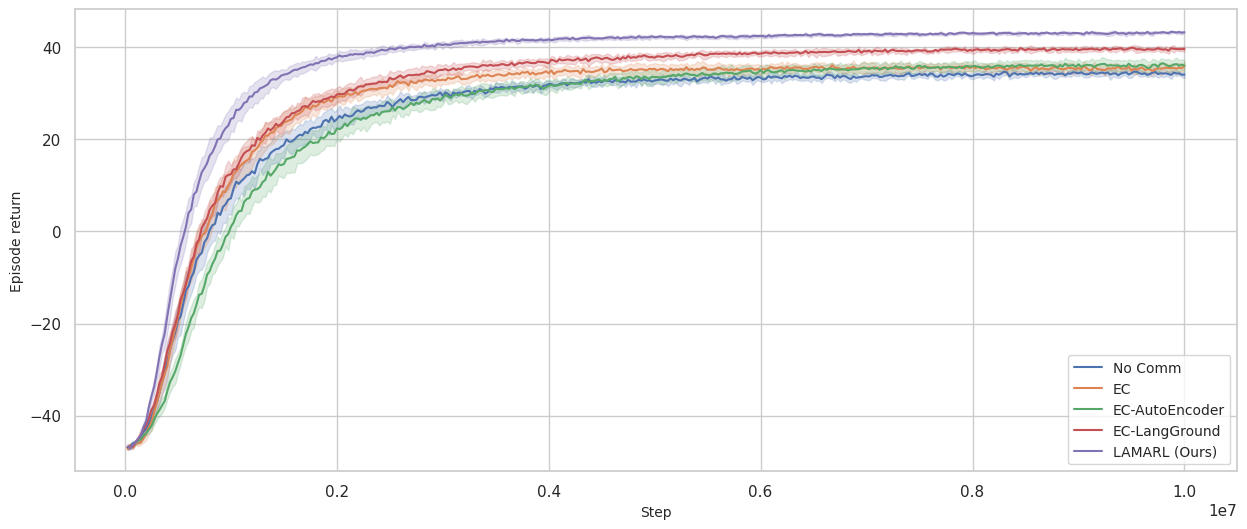

In [9]:
lang = load_mov_avg(
    "../models/magym_PredPrey_RGB/12s50np_lang/train_data/", 
    "LAMARL (Ours)", 
    25000, max_n_runs=7)
ec2_ae = load_mov_avg(
     "../models/magym_PredPrey_RGB/12s50np_ec2_ae/train_data/", 
     "EC-AutoEncoder", 
     25000, max_n_runs=7)
ec = load_mov_avg(
     "../models/magym_PredPrey_RGB/12s50np_ec2/train_data/", 
     "EC", 
     25000, max_n_runs=7)
ec4_lg = load_mov_avg(
     "../models/magym_PredPrey_RGB/12s50np_ec4_lg/train_data/", 
     "EC-LangGround", 
     25000, max_n_runs=7)
noc = load_mov_avg(
     "../models/magym_PredPrey_RGB/12s50np_noc/train_data/", 
     "No Comm", 
     25000, max_n_runs=7)

plot_runs([noc, ec, ec2_ae, ec4_lg, lang], y="Episode return")

Ablation

Model ../models/magym_PredPrey_RGB/18s50np_lang/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_lang_nocomm/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_oracle_nolang/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_oracle/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_obs/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/18s50np_noc/train_data/... run10.csv... run11.csv... run6.csv... run15.csv... run7.csv... run1.csv... run9.csv... done.


/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

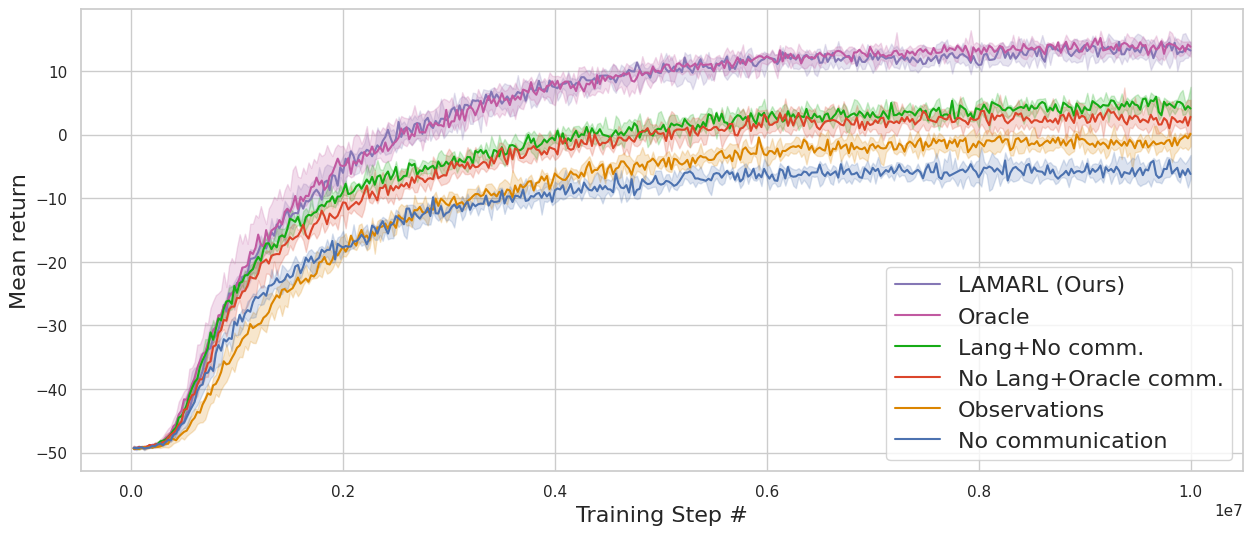

In [7]:
lang = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_lang/train_data/", 
    "LAMARL (Ours)", 
    25000, max_n_runs=7)
lang_noc = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_lang_nocomm/train_data/", 
    "Lang+No comm.", 
    25000, max_n_runs=7)
or_nolang = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_oracle_nolang/train_data/", 
    "No Lang+Oracle comm.", 
    25000, max_n_runs=7)
oracl = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_oracle/train_data/", 
    "Oracle", 
    25000, max_n_runs=7)
obs = load_mov_avg(
    "../models/magym_PredPrey_RGB/18s50np_obs/train_data/", 
    "Observations", 
    25000, max_n_runs=7)
noc = load_mov_avg(
     "../models/magym_PredPrey_RGB/18s50np_noc/train_data/", 
     "No communication", 
     25000, max_n_runs=7)


plot_runs([lang, oracl, lang_noc, or_nolang, obs, noc], y="Episode return", estim="median", err="ci", 
          fs=16, ax_xlabel="Training Step #", ax_ylabel="Mean return",
          colors={
              "No communication": "#4c72b0",
              "LAMARL (Ours)": "#8577b5",
              "No Lang+Oracle comm.": "#DB452B", 
              "Lang+No comm.": "#16AB16",
              "Observations": "#DB8500",
              "Oracle": "#C159A1"
          })

## Transfer

Model ../models/magym_PredPrey_RGB/Ad_12_18s50np_lang0001/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/Ad_12_18s50np_ec2_ae0001/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/Ad_12_18s50np_ec20001/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/Ad_12_18s50np_ec4_lg0001/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_PredPrey_RGB/Ad_12_18s50np_noc0001/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.


/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

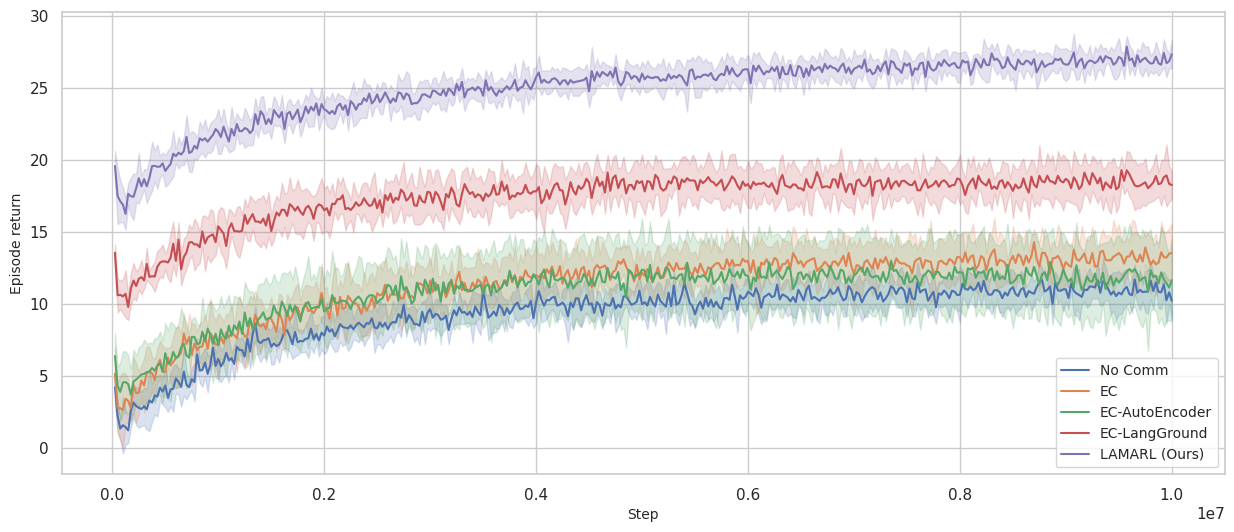

In [3]:
ad_lang = load_mov_avg(
    "../models/magym_PredPrey_RGB/Ad_12_18s50np_lang0001/train_data/", 
    "LAMARL (Ours)", 
    25000, max_n_runs=7)
ad_ec2_ae = load_mov_avg(
     "../models/magym_PredPrey_RGB/Ad_12_18s50np_ec2_ae0001/train_data/", 
     "EC-AutoEncoder", 
     25000, max_n_runs=7)
ad_ec = load_mov_avg(
     "../models/magym_PredPrey_RGB/Ad_12_18s50np_ec20001/train_data/", 
     "EC", 
     25000, max_n_runs=7)
ad_ec4_lg = load_mov_avg(
     "../models/magym_PredPrey_RGB/Ad_12_18s50np_ec4_lg0001/train_data/", 
     "EC-LangGround", 
     25000, max_n_runs=7)
ad_noc = load_mov_avg(
     "../models/magym_PredPrey_RGB/Ad_12_18s50np_noc0001/train_data/", 
     "No Comm", 
     25000, max_n_runs=7)

plot_runs([ad_noc, ad_ec, ad_ec2_ae, ad_ec4_lg, ad_lang], y="Episode return")

In [34]:
ad_noc["Step"] += 10000000
ad_lang["Step"] += 10000000
ad_ec["Step"] += 10000000
ad_ec2_ae["Step"] += 10000000
ad_ec4_lg["Step"] += 10000000

In [35]:
# colors={
#     "No Comm": "#4c72b0",
#     "LAMARL (Ours)": "#8577b5",
#     "No Lang+Oracle comm.": "#DB452B", 
#     "Lang+No comm.": "#16AB16",
#     "Observations": "#DB8500",
#     "Oracle": "#C159A1"
# }
colors = {}

noc_18["Step"] += 10000000
noc_18["Name"] = "No Comm (18)"
colors["No Comm (18)"] = "#94c0de"

lang_18["Step"] += 10000000
lang_18["Name"] = "LAMARL (Ours) (18)"
colors["LAMARL (Ours) (18)"] = "#a78ac2"

ec_18["Step"] += 10000000
ec_18["Name"] = "EC (18)"
colors["EC (18)"] = "#edb78b"

ec_ae_18["Step"] += 10000000
ec_ae_18["Name"] = "EC-AutoEncoder (18)"
colors["EC-AutoEncoder (18)"] = "#86b586"

ec_lg_18["Step"] += 10000000
ec_lg_18["Name"] = "EC-LangGround (18)"
colors["EC-LangGround (18)"] = "#d68686"



/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

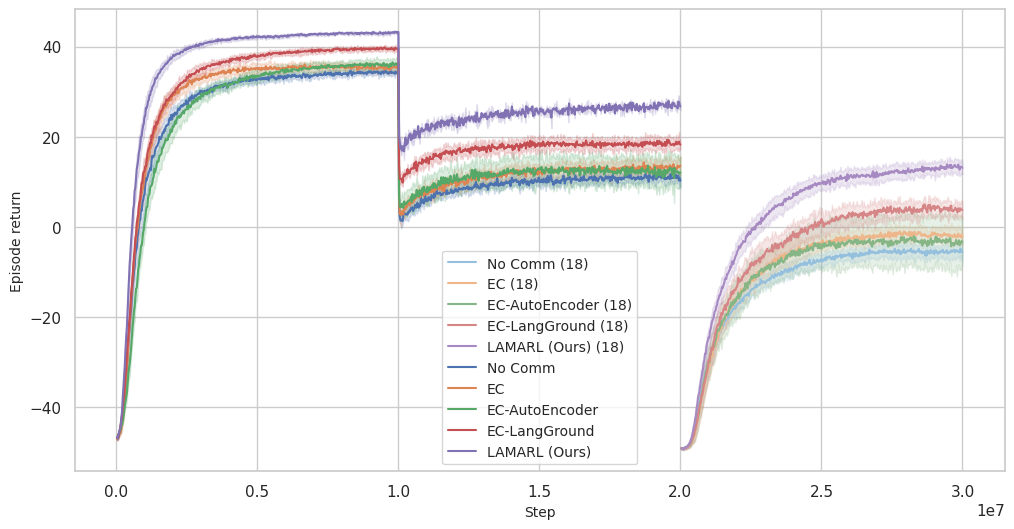

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_runs([noc_18, ec_18, ec_ae_18, ec_lg_18, lang_18], 
          y="Episode return", ax=ax, no_legend=True, colors=colors)

plot_runs([ad_noc, noc, ad_ec, ec, ec2_ae, ad_ec2_ae, ec4_lg, ad_ec4_lg, lang, ad_lang], 
          y="Episode return", ax=ax)

# Foraging

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run13.csv - run12.csv - run14.csv - run15.csv - run5.csv - 

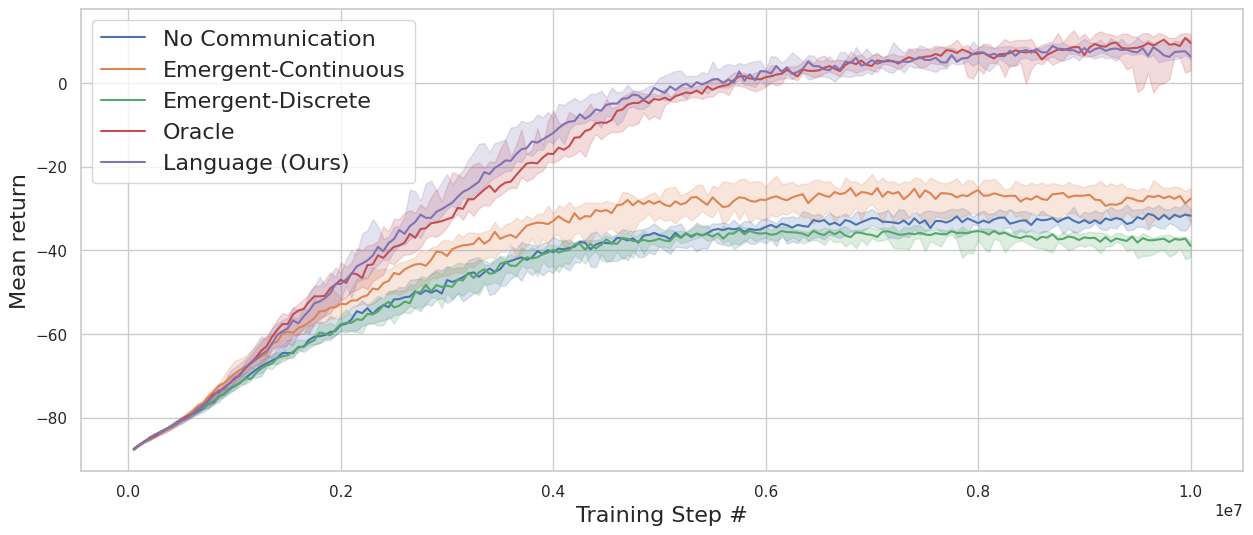

In [6]:
perf = load_mov_avg(
    "../models/magym_Foraging/18o5_perf/train_data/", 
    "Oracle", 
    50000)
lang = load_mov_avg(
    "../models/magym_Foraging/18o5_lang/train_data/", 
    "Language (Ours)", 
    50000)
ec = load_mov_avg(
    "../models/magym_Foraging/18o5_ec2/train_data/", 
    "Emergent-Continuous", 
    50000)
ed = load_mov_avg(
    "../models/magym_Foraging/18o5_edl/train_data/", 
    "Emergent-Discrete", 
    50000)
noc = load_mov_avg(
    "../models/magym_Foraging/18o5_no_comm/train_data/", 
    "No Communication", 
    50000)

plot_runs([noc, ec, ed, perf, lang], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")

### RGB

run10.csv - run11.csv - run6.csv - run15.csv - run7.csv - run1.csv - run9.csv - run3.csv - run14.csv - run12.csv - run5.csv - run2.csv - run13.csv - run8.csv - run4.csv - run10.csv - run11.csv - run6.csv - run15.csv - run7.csv - run1.csv - run9.csv - run3.csv - run14.csv - run12.csv - run5.csv - run2.csv - run13.csv - run8.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run10.csv - run11.csv - run6.csv - run15.csv - run7.csv - run1.csv - run9.csv - run3.csv - run14.csv - run12.csv - run5.csv - run2.csv - run13.csv - run8.csv - run4.csv - run10.csv - run11.csv - run6.csv - run15.csv - run7.csv - run1.csv - run9.csv - run3.csv - run14.csv - run12.csv - run5.csv - run2.csv - run13.csv - run8.csv - run4.csv - run10.csv - run11.csv - run6.csv - run15.csv - run7.csv - run1.csv - run9.csv - run3.csv - run14.csv - run12.csv - run5.csv - run2.csv - run13.csv - run8.csv - run4.csv - 

/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

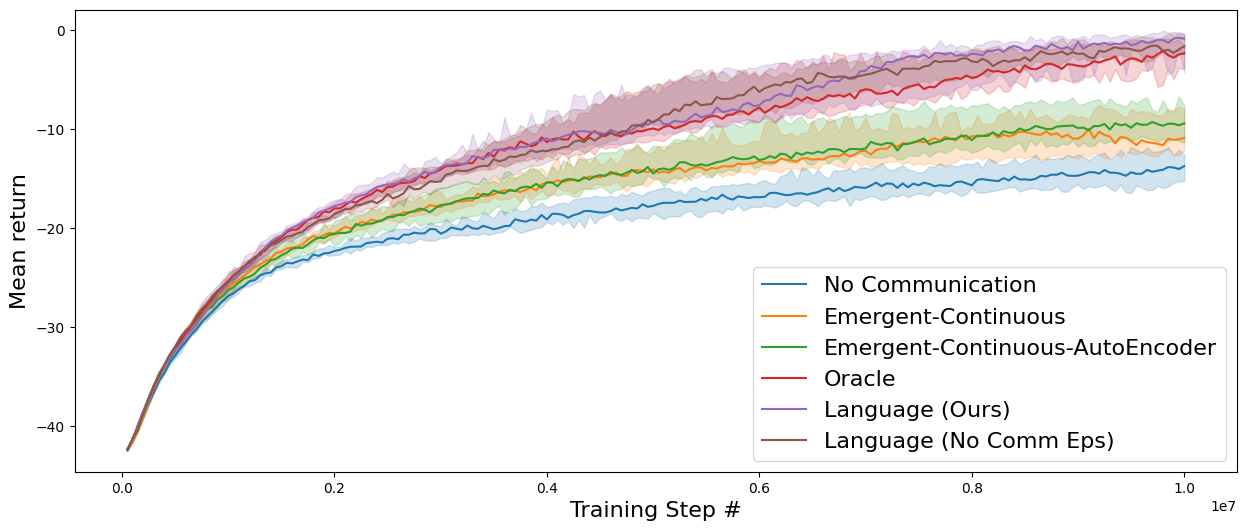

In [2]:
oracle = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_oracle/train_data/", 
    "Oracle", 
    50000)
lang = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_lang/train_data/", 
    "Language (Ours)", 
    50000)
lang_ce0 = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_lang_ce0/train_data/", 
    "Language (No Comm Eps)", 
    50000)
ec = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_ec2/train_data/", 
    "Emergent-Continuous", 
    50000)
ec_ae = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_ec2_ae/train_data/", 
    "Emergent-Continuous-AutoEncoder", 
    50000)
noc = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_noc/train_data/", 
    "No Communication", 
    50000)

plot_runs([noc, ec, ec_ae, oracle, lang, lang_ce0], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")

run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - run6.csv - run7.csv - run1.csv - run3.csv - run5.csv - run2.csv - run4.csv - 

/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

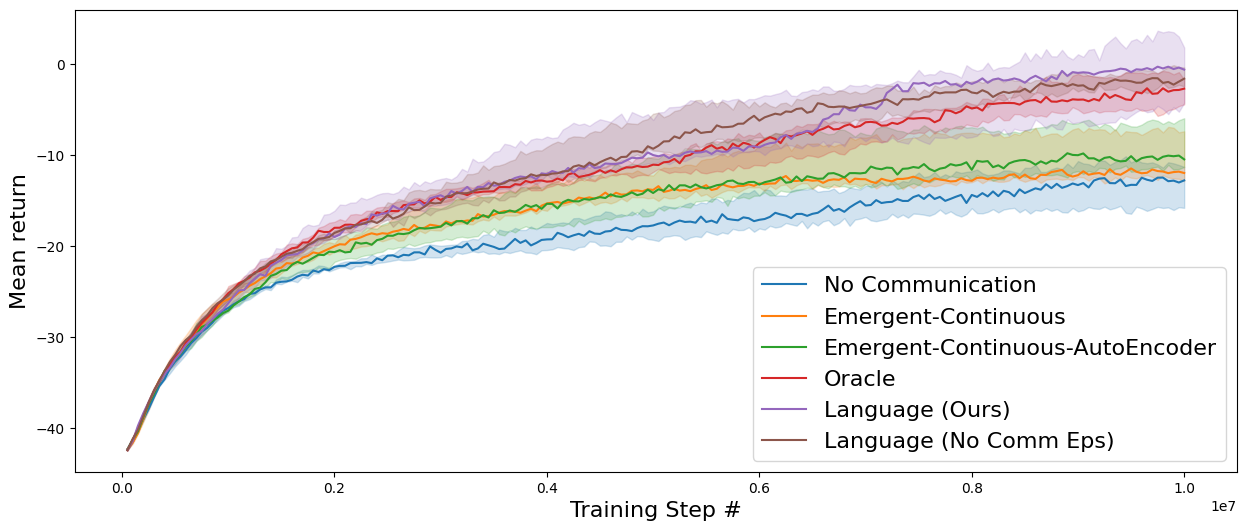

In [3]:
oracle = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_oracle/train_data_7/", 
    "Oracle", 
    50000)
lang = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_lang/train_data_7/", 
    "Language (Ours)", 
    50000)
lang_ce0 = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_lang_ce0/train_data/", 
    "Language (No Comm Eps)", 
    50000)
ec = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_ec2/train_data_7/", 
    "Emergent-Continuous", 
    50000)
ec_ae = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_ec2_ae/train_data_7/", 
    "Emergent-Continuous-AutoEncoder", 
    50000)
noc = load_mov_avg(
    "../models/magym_Foraging_RGB/18s50_noc/train_data_7/", 
    "No Communication", 
    50000)

plot_runs([noc, ec, ec_ae, oracle, lang, lang_ce0], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")

Model ../models/magym_Foraging_RGB/18_ec2_ae/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_Foraging_RGB/18_ec4_lg/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_Foraging_RGB/18_lang_ce0/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_Foraging_RGB/18_ec2/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.
Model ../models/magym_Foraging_RGB/18_noc/train_data/... run6.csv... run7.csv... run1.csv... run3.csv... run5.csv... run2.csv... run4.csv... done.


/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis

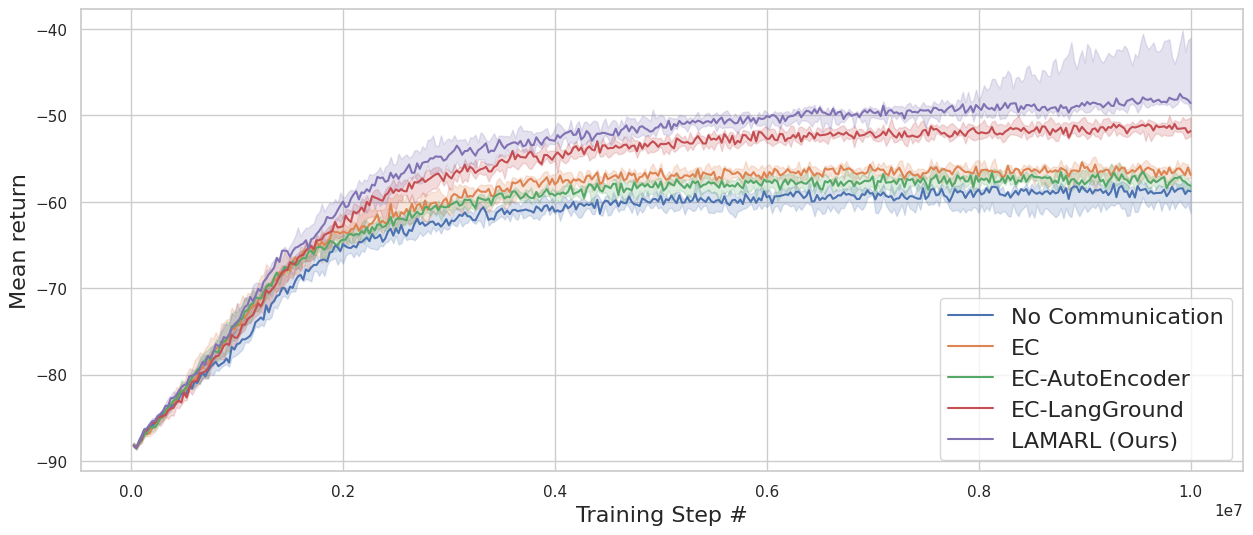

In [5]:
ec_ae = load_mov_avg(
    "../models/magym_Foraging_RGB/18_ec2_ae/train_data/", 
    "EC-AutoEncoder", 
    25000)
ec_lg = load_mov_avg(
    "../models/magym_Foraging_RGB/18_ec4_lg/train_data/", 
    "EC-LangGround", 
    25000)
lang_ce0 = load_mov_avg(
    "../models/magym_Foraging_RGB/18_lang_ce0/train_data/", 
    "LAMARL (Ours)", 
    25000)
ec = load_mov_avg(
    "../models/magym_Foraging_RGB/18_ec2/train_data/", 
    "EC", 
    25000)
noc = load_mov_avg(
    "../models/magym_Foraging_RGB/18_noc/train_data/", 
    "No Communication", 
    25000)

plot_runs([noc, ec, ec_ae, ec_lg, lang_ce0], y="Episode return", estim="median", err="ci", fs=16, 
          ax_xlabel="Training Step #", ax_ylabel="Mean return")